In [1]:
#nadare_data_dir = "/kaggle/input/nadare-4sq-data"
#nadare_feature_dir = "/kaggle/input/nadare-4sq-data/FEAT20/"
#nadare_util_dir = "/kaggle/input/nadare-4sq-data/common_utils/"
nadare_feature_dir = "../feature/FEAT30/"
nadare_util_dir = "../feature/common_utils/"


import os
import numpy as np
import pandas as pd

In [2]:
!unzip {nadare_util_dir}pykakasi_deps.dontopenthiskaggle/pykakasi_deps.dontopenthiskaggle -d .

'unzip' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [ ]:
!conda install ./pykakasi_deps/offline_pykakasi.tar.bz2
!conda install ./pykakasi_deps/offline_jaconv.tar.bz2
!conda install ./pykakasi_deps/offline_deprecated.tar.bz2

In [5]:
!pip install {nadare_util_dir}tensorflow_text-2.6.0-cp37-cp37m-manylinux1_x86_64.whl --no-deps
!pip install {nadare_util_dir}tensorflow_ranking-0.5.0-py2.py3-none-any.whl --no-deps
!pip install {nadare_util_dir}mojimoji-0.0.12-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps

In [6]:
!pip install {nadare_util_dir}SudachiPy-0.6.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl --no-deps
!pip install {nadare_util_dir}SudachiDict_core-20220519-py3-none-any.whl --no-deps
!pip install {nadare_util_dir}SudachiDict_full-20220519-py3-none-any.whl --no-deps
!pip install {nadare_util_dir}pythainlp-3.0.8-py3-none-any.whl --no-deps
!pip install {nadare_util_dir}tinydb-4.7.0-py3-none-any.whl --no-deps

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as tf_text

from tqdm.notebook import tqdm
import re

import gc

In [3]:
import pandas as pd

In [4]:
#train_df = pd.read_csv("../input/foursquare-location-matching/train.csv", encoding="utf-8")
test_df = pd.read_csv("../input/foursquare-location-matching/train.csv", encoding="utf-8")
#test_df.loc[0, "name"] = np.NaN

In [5]:
test_id_map = {v: i for i, v in enumerate(test_df["id"].values)}
test_df["ix"] = test_df["id"].map(test_id_map)
test_df["categories"] = test_df["categories"].fillna("")
test_df["pid"] = -1
test_df["group"] = -1

In [6]:
from fasttext import load_model
ft_model = load_model(nadare_util_dir + "lid.176.bin")
def predict_language(text):
    label, prob = ft_model.predict(text, 1)
    return list(zip([l.replace("__label__", "") for l in label], prob))[0][0]

test_df["name_language"] = np.vectorize(predict_language)(test_df["name"].fillna(""))
test_df["address_language"] = np.vectorize(predict_language)(test_df["address"].fillna(""))

def language_pattern(country, language):
    if country == "JP":
        return 0
    elif country == "TH":
        return 1
    elif country == "CN":
        return 2
    elif language == "ja":
        return 0
    elif language == "th":
        return 1
    elif language == "zh":
        return 2
    else:
        return 3
    
test_df["name_handle_pattern"] = np.vectorize(language_pattern)(test_df["country"], test_df["name_language"])     
test_df["address_handle_pattern"] = np.vectorize(language_pattern)(test_df["country"], test_df["address_language"])   
lang_vc = test_df["name_language"].value_counts()
del ft_model

In [7]:
from num2words import num2words
from collections import defaultdict

num2words_languages = ['en', 'tr', 'ru', 'es', 'de', 'th', 'id', 'fr', 'pt', 'it', 'nl',
       'ko', 'ar', 'sv', 'uk', "pl"]

word_number_df = []
for lang in tqdm(num2words_languages):
    for i in range(1001):
        try:
            word = num2words(i, lang=lang)
        except:
            word = np.NaN
        try:
            ordinal = num2words(i, lang=lang, to="ordinal")
        except:
            ordinal = np.NaN
        try:
            ordinal_num = num2words(i, lang=lang, to="ordinal_num")
        except:
            ordinal_num = np.NaN
        if (pd.isna(ordinal)) or (pd.isna(ordinal_num)) or (ordinal == ordinal_num):
            ordinal_num = i
        if lang == "ko" and not pd.isna(ordinal):
            ordinal = ordinal[:-3]
            ordinal_num = ordinal_num[:-3] 
        
        word_number_df.append({"lang": lang,
                               "number": i,
                               "word": word,
                               "ordinal": ordinal,
                               "ordinal_num": ordinal_num})

word_number_df = pd.DataFrame(word_number_df)
word_number_df["lang_count"] = word_number_df["lang"].apply(lambda x: lang_vc.get(x, 0))

word2num_dict = {}
possibly_have_next_dict = {}

for i, row in word_number_df.sort_values(by="lang_count").iterrows():
    if not pd.isna(row["word"]):
        word = row["word"]
        if not word in possibly_have_next_dict.keys():
            possibly_have_next_dict[word] = False

        word2num_dict[word] = str(row["number"])
        word2num_dict[word.replace("-", " ")] = str(row["number"])
        
        wsp = word.split()
        for i in range(1, len(wsp)-1):
            possibly_have_next_dict[" ".join(wsp[:i])] = True
        wsp = word.replace("-", " ").split()[:-1]
        for i in range(1, len(wsp)-1):
            possibly_have_next_dict[" ".join(wsp[:i])] = True
        
    if (not pd.isna(row["ordinal"])) and (not pd.isna(row["ordinal_num"])):
        word = row["ordinal"]
        if not word in possibly_have_next_dict.keys():
            possibly_have_next_dict[word] = False
        word2num_dict[word] = str(row["ordinal_num"])
        word2num_dict[word.replace("-", " ")] = str(row["ordinal_num"])
        
        wsp = word.split()
        for i in range(1, len(wsp)-1):
            possibly_have_next_dict[" ".join(wsp[:i])] = True
        wsp = word.replace("-", " ").split()[:-1]
        for i in range(1, len(wsp)-1):
            possibly_have_next_dict[" ".join(wsp[:i])] = True
        

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
import string
import pycnnum
import pythainlp
from pythainlp.util import thai_digit_to_arabic_digit
from sudachipy import Dictionary, SplitMode
import mojimoji
import pykakasi
from unidecode import unidecode
import emoji

emoji_set = set()
for k, v in emoji.UNICODE_EMOJI.items():
    emoji_set.update(v.keys())
thai_word2num_dict = {num2words(i, lang="th"):str(i) for i in range(10001)}
CHINESE_DIGITS_PATTERN = re.compile(r'[〇〇零一二三四五六七八九零壹贰叁肆伍陆柒捌玖十百千万拾佰仟萬]+')
remove_punctuations = '!"#$%\'()*+,./:;<=>?@[\\]^_`{|}~'
punctuation_translater = str.maketrans(remove_punctuations, " "*len(remove_punctuations))
japanese_char2num_translater = str.maketrans("〇零一壱二弐三参四肆五伍六陸七漆八捌九玖", "00112233445566778899")


kakasi = pykakasi.kakasi()
kakasi.setMode('H', 'a')  # Convert Hiragana into alphabet
kakasi.setMode('K', 'a')  # Convert Katakana into alphabet
kakasi.setMode('J', 'a')  # Convert Kanji into alphabet
conversion = kakasi.getConverter()

force_katakana = pykakasi.kakasi()
kakasi.setMode('H', 'K')  # Convert Hiragana into alphabet
kakasi.setMode('K', 'K')  # Convert Katakana into alphabet
force_katakana.setMode('J', 'K')  # Convert Hiragana into alphabet
force_katakana_conversion = force_katakana.getConverter()

sudachi_tokenizer = Dictionary(dict_type="full").create()
sudachi_tokenize_mode = SplitMode.A

zh_segmenter = tf_text.HubModuleTokenizer(nadare_util_dir + "zh_segmentation")

def remove_emoji(x):
    return ''.join([c for c in x if c not in emoji_set])

def remove_marks(x):
    x = re.sub(r'[^a-zA-Z0-9& ]', ' ', x)
    x = re.sub(r' +', ' ', x)
    return x

def zenhan_normalize(x):
    return mojimoji.han_to_zen(mojimoji.zen_to_han(x, kana=False), digit=False, ascii=False)

def japanese_wakachi_reading(morphemes):
    readings = []
    for m in morphemes:
        if (m.normalized_form() == " ") or (m.reading_form() == "キゴウ"):
            continue
        if m.normalized_form().endswith("丁目") and m.normalized_form() != "丁目":
            norm = m.normalized_form().translate(japanese_char2num_translater)
            norm = re.sub(r"(\d+)", r" \1 ", "6丁目")
            rs = japanese_wakachi_reading(sudachi_tokenizer.tokenize(norm, sudachi_tokenize_mode))
            readings.extend(rs)
        elif m.normalized_form().isdigit():
            readings.append(m.normalized_form())
        else:
            readings.append(force_katakana_conversion.do(m.reading_form()))
    return readings

def handle_japanese(x):
    x = zenhan_normalize(x)
    morphemes = sudachi_tokenizer.tokenize(x, sudachi_tokenize_mode)
    reading_forms = japanese_wakachi_reading(morphemes)
    romanize_forms = conversion.do(" ".join(reading_forms))
    return " ".join(reading_forms), romanize_forms

def decode_list(x):
    if type(x) is list:
        return list(map(decode_list, x))
    return x.decode("UTF-8")

def decode_utf8_tensor(x):
    return list(map(decode_list, x.to_list()))

def handle_chinese(x):
    x = x.replace("'", "").translate(punctuation_translater).lower()
    if re.fullmatch("\s*", x):
        return "", ""
    with tf.device("CPU:0"):
        words_list = decode_utf8_tensor(zh_segmenter.tokenize(x.split()))
        
    number_words = []
    romanized_words = []
    for words in words_list:
        num_word = []
        roman_word = []
        for word in words:
            if re.fullmatch(CHINESE_DIGITS_PATTERN, word):
                word = str(pycnnum.cn2num(word))
            if (word[0]) == "第" and re.fullmatch(CHINESE_DIGITS_PATTERN, word[1:]):
                num = str(pycnnum.cn2num(word[1:]))
                word = "第"
                num_word.append(word + num)
                roman_word.append(unidecode(word[0]).lower().replace(" ", "") + " " + num)
            else:
                num_word.append(word)
                roman_word.append(unidecode(word).lower().replace(" ", ""))
        number_words.append("".join(num_word))
        romanized_words.append(" ".join(roman_word))
    return " ".join(number_words), " ".join(romanized_words)

def handle_thai(x):
    x = thai_digit_to_arabic_digit(x)
    tokenized_word = pythainlp.tokenize.word_tokenize(x, engine="newmm")
    number_words = []
    romanized_words = []
    for word in tokenized_word:
        word = thai_word2num_dict.get(word, word)
        number_words.append(word)
        try:
            romanized_words.append(pythainlp.romanize(word, engine='royin'))
        except:
            pass
    return "".join(number_words), " ".join(romanized_words)


def language_normalize(word):
    result = []
    word = word.replace("'", "").translate(punctuation_translater).lower()
    tmp = ""
    for w in word.split():
        if len(tmp):
            tmp = tmp + " " + w
            if tmp in possibly_have_next_dict.keys():
                if possibly_have_next_dict[tmp]:
                    continue
                else:
                    result.append(word2num_dict[tmp])
                    tmp = ""
        else:
            if w in possibly_have_next_dict.keys():
                if possibly_have_next_dict[w]:
                    tmp = w
                    continue
                else:
                    result.append(word2num_dict[w])
            else:
                result.append(w)
    if len(tmp):
        result.append(word2num_dict.get(tmp, tmp))
            
    return re.sub(r' +', ' ', " ".join(result))

def language_handle(handle_pattern, text):
    if handle_pattern == 0:
        normalized, romanized = handle_japanese(text)
    elif handle_pattern == 1:
        normalized, romanized = handle_thai(text)
    elif handle_pattern == 2:
        normalized, romanized = handle_chinese(text)
    return normalized, romanized


C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:22: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi.setMode('H', 'a')  # Convert Hiragana into alphabet
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:23: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi.setMode('K', 'a')  # Convert Katakana into alphabet
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:24: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi.setMode('J', 'a')  # Convert Kanji into alphabet
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:25: DeprecationWarning: Call to deprecated method getConverter. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  conversion = kakasi.getConverter()
C:\Users\n

In [9]:
name_handle_index = np.where((test_df["name_handle_pattern"] <= 2) & (~test_df["name"].isna()))[0]

name_normalized = []
name_romanized = []
for pattern, name in tqdm(zip(test_df["name_handle_pattern"].values[name_handle_index],
                              test_df["name"].fillna("").astype(str).values[name_handle_index]), total=len(name_handle_index)):
    normalized, romanized = language_handle(pattern, name)
    name_normalized.append(normalized)
    name_romanized.append(romanized)

  0%|          | 0/150443 [00:00<?, ?it/s]

C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:62: DeprecationWarning: Call to deprecated method do. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  readings.append(force_katakana_conversion.do(m.reading_form()))
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:69: DeprecationWarning: Call to deprecated method do. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  romanize_forms = conversion.do(" ".join(reading_forms))


In [10]:
address_handle_index = np.where((test_df["address_handle_pattern"] <= 2) & (~test_df["address"].isna()))[0]

address_normalized = []
address_romanized = []
for pattern, address in tqdm(zip(test_df["address_handle_pattern"].values[address_handle_index],
                              test_df["address"].fillna("").astype(str).values[address_handle_index]), total=len(address_handle_index)):
    normalized, romanized = language_handle(pattern, address)
    address_normalized.append(normalized)
    address_romanized.append(romanized)

  0%|          | 0/90478 [00:00<?, ?it/s]

C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:62: DeprecationWarning: Call to deprecated method do. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  readings.append(force_katakana_conversion.do(m.reading_form()))
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/2681526445.py:69: DeprecationWarning: Call to deprecated method do. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  romanize_forms = conversion.do(" ".join(reading_forms))


In [11]:
import gc
del zh_segmenter, kakasi, conversion, sudachi_tokenizer
gc.collect()

10804

In [12]:
test_df["name_normalized"] = np.vectorize(language_normalize)(test_df["name"].fillna("").astype(str))
test_df["address_normalized"] = np.vectorize(language_normalize)(test_df["address"].fillna("").astype(str))


from_cols = ["name_normalized", "address_normalized"]
to_cols = ['sp_name', "sp_address_raw"]

for from_, to_ in zip(from_cols, to_cols):
    test_df[to_] = test_df[from_].fillna('').apply(unidecode)
    
test_df.loc[name_handle_index, "name_normalized"] = name_normalized
test_df.loc[name_handle_index, "sp_name"] = name_romanized

test_df.loc[address_handle_index, "address_normalized"] = address_normalized
test_df.loc[address_handle_index, "sp_address_raw"] = address_romanized

for from_, to_ in zip(from_cols, to_cols):
    test_df[to_] = test_df[to_].apply(unidecode)
    test_df[to_] = test_df[to_].str.lower()
    test_df[to_] = test_df[to_].apply(remove_emoji)
    test_df[to_] = test_df[to_].apply(remove_marks)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
address_index = np.where(~np.vectorize(lambda x: bool(re.fullmatch("\s*", x)))(test_df["sp_address_raw"].fillna("")))[0]
knn = KNeighborsRegressor(n_neighbors=min(3, (~test_df["address"].isna()).sum()), 
                          metric='haversine', 
                          n_jobs=-1)
knn.fit(np.deg2rad(test_df[['latitude','longitude']].values)[address_index], address_index)
address_neiighbor = address_index[knn.kneighbors(np.deg2rad(test_df[['latitude','longitude']].values))[1]]
test_df["sp_address"] = np.vectorize(lambda x: " ".join(x))(pd.Series(test_df["sp_address_raw"].values[address_neiighbor].tolist()))


In [14]:
test_df["sp_name"] = test_df["sp_name"].apply(remove_marks)
test_df["sp_address"] = test_df["sp_address"].apply(remove_marks)

In [15]:
#test_df[["sp_name", "sp_address", "sp_address_raw"]].to_csv("../processed/sp_input2.csv", index=None)

In [16]:
#test_df[["sp_name", "sp_address", "sp_address_raw"]] = pd.read_csv("../processed/sp_input2.csv").fillna(" ")

In [17]:
import os

country_index_df = pd.read_csv(nadare_feature_dir + 'country_tsp_index.csv', encoding="utf-8")
state_index_df = pd.read_csv(nadare_feature_dir + 'state_tsp_index.csv', encoding="utf-8")
city_index_df = pd.read_csv(nadare_feature_dir + 'city_tsp_index.csv', encoding="utf-8")
geo_name_index_df = pd.read_csv(nadare_feature_dir + 'geo_name_tsp_index.csv', encoding="utf-8")
category_index_df = pd.read_csv(nadare_feature_dir + 'category_tsp_index.csv', encoding="utf-8").fillna("nan")


In [18]:
country_index_map = {country: i for country, i in country_index_df[["country", "country_index"]].values}
state_index_map = {state: i for state, i in state_index_df[["state", "state_index"]].values}
city_index_map = {city: i for city, i in city_index_df[["city", "city_index"]].values}
geo_name_index_map = {geo_name: i for geo_name, i in geo_name_index_df[["geo_name", "geo_name_index"]].values}

In [19]:
def haversine(X, Y):
    delta = Y - X
    x_lats = tf.gather(X, 0, axis=-1)
    y_lats = tf.gather(Y, 0, axis=-1)
    dlat = tf.gather(delta, 0, axis=-1)
    dlon = tf.gather(delta, 1, axis=-1)

    a = tf.sin(dlat/2) * tf.sin(dlat/2) + tf.cos(x_lats) * tf.cos(y_lats) * tf.sin(dlon/2) * tf.sin(dlon/2)
    c = 2 * tf.math.atan2(tf.sqrt(a), tf.sqrt(1-a))
    return c

In [20]:
category_ix_dict = {k: v for k, v in category_index_df[["category", "category_ix"]].values}

In [21]:
len(category_ix_dict)

911

In [22]:
def get_value_with_default(dict_, value, default=0):
    return np.vectorize(lambda x: dict_.get(x, default))(value)

def get_category_ix(df, category_ix_dict):
    cat_pairs = []
    all_category = set()
    for row in df["categories"].drop_duplicates().dropna().values:
        for cat in row.split(", "):
            if len(cat):
                cat_pairs.append([row, cat])
                all_category.add(cat)

    category_df = pd.DataFrame(cat_pairs, columns=["categories", "category"])
    categories_df = df[["ix", "categories"]].merge(category_df, on="categories", how="left").sort_values(by="ix")

    categories_df["category_ix"] = get_value_with_default(category_ix_dict, categories_df["category"].values, -1)
    categories_df = categories_df[categories_df["category_ix"] >= 0]
    categories_ix = tf.RaggedTensor.from_value_rowids(values=tf.constant(categories_df["category_ix"].values, "int32"),
                                                              value_rowids=tf.constant(categories_df["ix"].values, "int32"),
                                                              nrows=len(df))
    return categories_ix
category_ix_dict = {k: v for k, v in category_index_df[["category", "category_ix"]].values}
test_categories_ix = get_category_ix(test_df, category_ix_dict)

In [23]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1, 
                          metric='haversine', 
                          n_jobs=-1)
knn.fit(np.deg2rad(city_index_df[['latitude','longitude']]), city_index_df["city_index"])
pseudo_index = knn.kneighbors(np.deg2rad(test_df[['latitude','longitude']]))[1].T[0]
test_df["pseudo_city"] = np.where(test_df["city"].isin(city_index_df["city"].values), test_df["city"].values, city_index_df["city"][pseudo_index].values)
test_df["pseudo_city_ix"] = test_df["pseudo_city"].map(city_index_map)

In [24]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1, 
                          metric='haversine', 
                          n_jobs=-1)
knn.fit(np.deg2rad(state_index_df[['latitude','longitude']]), state_index_df["state_index"])
pseudo_index = knn.kneighbors(np.deg2rad(test_df[['latitude','longitude']]))[1].T[0]
test_df["pseudo_state"] = np.where(test_df["state"].isin(state_index_df["state"].values), test_df["state"].values, state_index_df["state"][pseudo_index].values)
test_df["pseudo_state_ix"] = test_df["pseudo_state"].map(state_index_map)

In [25]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1, 
                          metric='haversine', 
                          n_jobs=-1)
knn.fit(np.deg2rad(geo_name_index_df[['latitude','longitude']]), geo_name_index_df["geo_name_index"])
pseudo_index = knn.kneighbors(np.deg2rad(test_df[['latitude','longitude']]))[1].T[0]
test_df["pseudo_geo_name_ix"] = pseudo_index

In [26]:
test_df["country_ix"] = get_value_with_default(country_index_map, test_df["country"], np.where(country_index_df["country"] == "NAN")[0][0])


In [27]:
ix_params_dict = {"country": {"dimention": 64, "num_category": len(country_index_df)+1},
                  "state": {"dimention": 64, "num_category": len(state_index_df)},
                  "city": {"dimention": 64, "num_category": len(city_index_df)},
                  "geo_name": {"dimention": 64, "num_category": len(geo_name_index_df)}
                  }
test_ix_values = {"country": tf.convert_to_tensor(test_df["country_ix"].values.astype(np.int32)),
                   "state": tf.convert_to_tensor(test_df["pseudo_state_ix"].values.astype(np.int32)),
                   "city": tf.convert_to_tensor(test_df["pseudo_city_ix"].values.astype(np.int32)),
                   "geo_name": tf.convert_to_tensor(test_df["pseudo_geo_name_ix"].values.astype(np.int32)),
                   }

class IxEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, ix_params_dict, num_layer=1, out_dim=128):
        super(IxEmbeddingLayer, self).__init__()
        self.ix_params_dict = ix_params_dict
        self.num_layer = num_layer
        self.out_dim = out_dim
        self.embedding_layers = {k: tf.keras.layers.Embedding(v["num_category"], v["dimention"]) for k, v in ix_params_dict.items()}
        self.denses = [tf.keras.layers.Dense(out_dim, activation="gelu")]
        self.out = tf.keras.layers.Dense(out_dim)
        self.drop_out = tf.keras.layers.Dropout(0.1)
    
    def call(self, ix_values):
        results = []
        for k, v in ix_values.items():
            results.append(self.embedding_layers[k](v))
        X = tf.concat(results, axis=-1)
        
        for i in range(self.num_layer):
            X = self.drop_out(self.denses[i](X))
        return self.out(X)
        

In [28]:
def approx_ranks(logits):
    r"""Computes approximate ranks given a list of logits.
    Given a list of logits, the rank of an item in the list is one plus the total
    number of items with a larger logit. In other words,
    rank_i = 1 + \sum_{j \neq i} I_{s_j > s_i},
    where "I" is the indicator function. The indicator function can be
    approximated by a generalized sigmoid:
    I_{s_j < s_i} \approx 1/(1 + exp(-(s_j - s_i)/temperature)).
    This function approximates the rank of an item using this sigmoid
    approximation to the indicator function. This technique is at the core
    of "A general approximation framework for direct optimization of
    information retrieval measures" by Qin et al.
    Args:
    logits: A `Tensor` with shape [batch_size, list_size]. Each value is the
      ranking score of the corresponding item.
    Returns:
    A `Tensor` of ranks with the same shape as logits.
    """
    list_size = tf.shape(input=logits)[1]
    x = tf.tile(tf.expand_dims(logits, 2), [1, 1, list_size])
    y = tf.tile(tf.expand_dims(logits, 1), [1, list_size, 1])
    pairs = tf.sigmoid(y - x)
    return tf.reduce_sum(input_tensor=pairs, axis=-1) + .5
    
    
class RankMSE(tf.keras.layers.Layer):
    def __init__(self):
        super(RankMSE, self).__init__()
    
    def call(self, y_true, y_pred):        
        weight = 1 / y_true
        rmse = tf.reduce_sum(tf.math.sqrt(tf.math.square(y_true - y_pred))*weight, axis=-1) / tf.reduce_sum(weight, axis=1)
        
        return tf.reduce_mean(rmse)

In [29]:
class MixerModel(tf.keras.Model):
    
    def __init__(self, name_model, address_model, ix_emb_layer, cat_emb_layer, num_layer=2, num_dim=128):
        super(MixerModel, self).__init__()
        self.num_layer = num_layer
        self.num_dim = num_dim
        self.name_model = name_model
        self.address_model = address_model
        self.ix_emb_layer = ix_emb_layer
        self.cat_emb_layer = cat_emb_layer
        
        self.tokenize_norm = [tf.keras.layers.LayerNormalization() for i in range(4)]
    
        self.drop_out = tf.keras.layers.Dropout(0.1)
        
        self.filter_denses = [tf.keras.layers.DepthwiseConv2D(kernel_size=(1, 4),
                                                              strides=1,
                                                              padding="valid",
                                                              depth_multiplier=4,
                                                              activation="gelu") for _ in range(self.num_layer)]
        self.out_denses = [tf.keras.layers.Dense(num_dim) for _ in range(self.num_layer)]
        
        #self.pointwise_filter_denses = [tf.keras.layers.Dense(num_dim, activation="gelu") for _ in range(self.num_layer)]
        #self.pointwise_out_denses = [tf.keras.layers.Dense(num_dim) for _ in range(self.num_layer)]
        self.norm_layers = [tf.keras.layers.LayerNormalization() for _ in range(self.num_layer)]
        
    def check_tensor(self, x, ix):
        if isinstance(x, tf.RaggedTensor):
            x = x.to_tensor()
        return x
        
    def call(self, info, training=False):
        ix, name, address, position, ix_values, categories, pids, size = info
        X_name = self.tokenize_norm[0](tf.reduce_sum(self.name_model(name), axis=-2))
        X_address = self.tokenize_norm[1](tf.reduce_sum(self.address_model(address), axis=-2))
        X_ix = self.tokenize_norm[2](self.drop_out(self.ix_emb_layer(ix_values)))
        X_categories = self.tokenize_norm[3](tf.reduce_sum(self.drop_out(self.cat_emb_layer(categories)), axis=-2))
        
        X = tf.stack([X_name, X_address, X_ix, X_categories], axis=-2)
        original_shape = tf.shape(X)
        X = tf.expand_dims(X, axis=1)
        expand_shape = tf.shape(X)
        for i in range(self.num_layer):
            X_ = self.norm_layers[i](X)
            X_ = self.out_denses[i](tf.reshape(self.filter_denses[i](X_), expand_shape))
            X = X + X_
        X = tf.reshape(X, original_shape)
        return tf.reduce_mean(X, axis=-2)

def simcse_task(mixer_model, loss_func, neighbor_info):
    X_a = tf.nn.l2_normalize(mixer_model(neighbor_info, training=True), axis=-1)
    X_b = tf.nn.l2_normalize(mixer_model(neighbor_info, training=True), axis=-1)
    
    X_p = tf.reshape(neighbor_info[-2], [-1, neighbor_info[-1]])
    
    N = tf.shape(X_p)[0]
    R = tf.shape(X_p)[1]
    
    shape = tf.shape(X_a)
    X_a = tf.reshape(X_a, [-1, neighbor_info[-1], shape[-1]])
    X_b = tf.reshape(X_b, [-1, neighbor_info[-1], shape[-1]])
    shape = tf.shape(X_a)
    
    cossim_c = tf.reshape(tf.einsum("nad,nbd->nab", X_a, X_b), [shape[0]*shape[1], shape[1]])
    cossim_r = tf.reshape(tf.einsum("nad,nbd->nab", tf.transpose(X_a, [1, 0, 2]), tf.transpose(X_b, [1, 0, 2])), [shape[0]*shape[1], shape[0]])
 
    mask_c = tf.reshape(tf.expand_dims(X_p, axis=1) != tf.expand_dims(X_p, axis=2), [shape[0]*shape[1], shape[1]])
    mask_r = tf.reshape(tf.expand_dims(X_p, axis=0) != tf.expand_dims(X_p, axis=1), [shape[0]*shape[1], shape[0]])    

    label_c = tf.reshape(tf.repeat(tf.expand_dims(tf.eye(tf.shape(X_a)[1]), axis=0), tf.shape(X_a)[0], axis=0), tf.shape(cossim_c))
    label_r = tf.reshape(tf.repeat(tf.expand_dims(tf.eye(tf.shape(X_a)[0]), axis=1), tf.shape(X_a)[1], axis=0), tf.shape(cossim_r))
    
    mask_c = tf.math.logical_or(label_c == 1., mask_c)
    mask_r = tf.math.logical_or(label_r == 1., mask_r)
    
    cossim_c = tf.where(mask_c, cossim_c, -1.)
    cossim_r = tf.where(mask_r, cossim_r, -1.)
    
    scale_c = tf.sqrt(2.) * tf.math.log(tf.cast(tf.shape(label_c)[1], "float32") - 1.)
    scale_r = tf.sqrt(2.) * tf.math.log(tf.cast(tf.shape(label_r)[1], "float32") - 1.)
    loss = loss_func(label_c, cossim_c * scale_c) + loss_func(label_r, cossim_r * scale_r)
    return loss


In [30]:
class CategoryEmbeddingLayer(tf.keras.layers.Layer):
    
    def __init__(self, num_categories, dim_categories, init_embedding=None):
        super(CategoryEmbeddingLayer, self).__init__()
        self.num_categories = num_categories
        self.dim_categories = dim_categories
        self.category_dense = tf.Variable(tf.keras.initializers.GlorotUniform()(shape=(num_categories, dim_categories)), trainable=True, name=self.name + "/category_embedding")
        if not init_embedding is None:
            self.category_dense.assign(init_embedding)
            
    def call(self, C):
        X = tf.gather(self.category_dense, C)
        return X

In [31]:
import tensorflow as tf
from tensorflow_text import SentencepieceTokenizer

class SupervisedContrastiveLoss(tf.keras.layers.Layer):
    def __init__(self, from_logits=False):
        super(SupervisedContrastiveLoss, self).__init__()
        if not from_logits:
            NotImplementedError
        
    @tf.function
    def call(self, true, pred, sample_weight=None):
        if sample_weight is None:
            sample_weight = tf.ones(tf.shape(pred), dtype=tf.float32)
        epred = tf.exp(pred) * sample_weight
        scale = tf.reduce_sum(epred, axis=1, keepdims=True)
        loss = tf.reduce_sum((tf.math.log(scale - epred * true) - true*pred) * true * sample_weight) / tf.reduce_sum(true*sample_weight)
        return loss
    
class SentencePieceEmbeddingLayer(tf.keras.layers.Layer):
    
    def __init__(self, vocab_size, out_dim, sp_model_path, init_embedding=None):
        super(SentencePieceEmbeddingLayer, self).__init__()
        self.vocab_size = vocab_size
        self.out_dim = out_dim
        model = open(sp_model_path, "rb").read()
        self.tokenizer = SentencepieceTokenizer(model)
        self.embedding = tf.keras.layers.Embedding(vocab_size, out_dim)
        if not init_embedding is None:
            self.embedding(0)
            self.embedding.trainable_variables[0].assign(init_embedding)
        self.drop_out = tf.keras.layers.Dropout(0.1)
    
    def call(self, X):
        token = self.tokenizer.tokenize(X)
        X = self.drop_out(self.embedding(token))
        return X
    
class DpConvWrapper(tf.keras.layers.Layer):
    
    def __init__(self, sp_layer, num_layer=2):
        super(DpConvWrapper, self).__init__()
        self.sp_layer = sp_layer
        self.num_layer = num_layer
        self.out_dim = self.sp_layer.out_dim
        self.norms = [tf.keras.layers.LayerNormalization() for i in range(num_layer)]
        self.dep_convs = [tf.keras.layers.DepthwiseConv1D(kernel_size=3, strides=1, padding="same", activation="gelu") for _ in range(num_layer)]
        self.denses = [tf.keras.layers.Dense(sp_layer.out_dim) for _ in range(num_layer)]
        self.drop_out = tf.keras.layers.Dropout(0.1)
        
        
    def call(self, X):
        token = name_dpc.sp_layer.tokenizer.tokenize(X) + 1
        start = tf.cast(tf.concat([tf.zeros([1], dtype="int64"), tf.cumsum(token.row_lengths())], axis=0), "int32")
        row_ids = tf.cast(token.value_rowids(), "int32")
        col_ids = tf.range(tf.shape(token.value_rowids())[0], dtype="int32") - tf.gather(start, token.value_rowids())
        X = self.drop_out(name_dpc.sp_layer.embedding(token.to_tensor(default_value=2)))
        rank = tf.rank(X)
        shape = tf.shape(X)
        
        for i in range(name_dpc.num_layer):
            X_ = name_dpc.norms[i](X)
            X_ = name_dpc.dep_convs[i](X_)
            X_ = name_dpc.denses[i](X_)
            X += X_
            
        X = tf.RaggedTensor.from_value_rowids(tf.gather_nd(X, tf.stack([row_ids, col_ids], axis=1)),
                                              token.value_rowids(),
                                              nrows=tf.cast(shape[0], "int64"))
        return X        

    
class SkipgramModel(tf.keras.Model):
    
    def __init__(self, name_spe):
        super(SkipgramModel, self).__init__()
        self.name_spe = name_spe
        
    #@tf.function(experimental_relax_shapes=True)
    def call(self, name, n_name, n_pid):
        X = skipgram_model.name_spe(name)
        X_sum_neighbor = tf.reduce_sum(skipgram_model.name_spe(tf.slice(n_name, [0, 1], [-1, -1])), axis=2).to_tensor()
        name_skip_loss = skipgram_model.skipgram_task(X, X_sum_neighbor, n_pid)

        return name_skip_loss
    
    #@tf.function(experimental_relax_shapes=True)
    def skipgram_task(self, X, X_sum_neighbor, n_pid):

        my_pid, other_pid = tf.split(n_pid, [1, tf.shape(n_pid)[1]-1], axis=1)
        
        X_sum = tf.reduce_sum(X, axis=1)
        X_sum_other = tf.gather(X_sum, X.value_rowids()) - X.values

        
        X_sum_norm = tf.nn.l2_normalize(X_sum, axis=1)
        X_sum_other_norm = tf.nn.l2_normalize(X_sum_other, axis=1)
        X_sum_neighbor_norm = tf.slice(tf.gather(tf.nn.l2_normalize(X_sum_neighbor, axis=-1), X.value_rowids()), [0, 1, 0], [-1, -1, -1])
        X_value_norm = tf.nn.l2_normalize(X.values, axis=1)
        

        correct_cossim = tf.expand_dims(tf.einsum("Vd,Vd->V", X_value_norm, X_sum_other_norm), axis=1)
        wrong_cossim = tf.einsum("Vd,Nd->VN", X_value_norm, X_sum_norm)
        neighbor_cossim = tf.einsum("Vd,VNd->VN", X_value_norm, X_sum_neighbor_norm)
        cossim = tf.concat([correct_cossim, wrong_cossim, neighbor_cossim], axis=1)

        rowwise_mask = tf.expand_dims(tf.gather(X.row_lengths(), X.value_rowids()) > 1, axis=1)
        sameid_mask = tf.concat([tf.expand_dims(tf.cast(X.value_rowids(), "int32"), axis=1) != tf.expand_dims(tf.range(tf.shape(X.row_lengths())[0] + 1)-1, axis=0),
                                 tf.ones(tf.gather(tf.shape(X_sum_neighbor_norm), [0, 1], axis=0), dtype="bool")], axis=1)
        same_pid_mask = tf.concat([tf.gather(my_pid, X.value_rowids(), axis=0) != tf.linalg.matrix_transpose(my_pid),
                                   tf.gather(my_pid, X.value_rowids()) != tf.gather(other_pid, X.value_rowids())], axis=1)
        
        mask = tf.math.logical_and(tf.math.logical_and(rowwise_mask, sameid_mask), same_pid_mask)
        label = tf.concat([tf.ones(tf.shape(correct_cossim)), tf.zeros(tf.shape(wrong_cossim)), tf.zeros(tf.shape(neighbor_cossim))], axis=1)
        
        # Fixed AdaCos paramet2r
        scale = tf.sqrt(2.) * tf.math.log(tf.cast(tf.shape(label)[1], "float32") - 1.)

        label = tf.where(mask, label, tf.zeros(tf.shape(mask)))
        pred = tf.where(mask, scale * cossim, scale * -1.)
        loss = tf.math.reduce_mean(tf.keras.losses.categorical_crossentropy(label, pred, from_logits=True))
        return loss   
    
class ClassifyTrainModel(tf.keras.Model):
    
    def __init__(self, name_model, address_model, ix_emb_layer, cat_emb_layer):
        super(ClassifyTrainModel, self).__init__()
        self.name_model = name_model
        self.address_model = address_model
        self.ix_emb_layer = ix_emb_layer
        self.cat_emb_layer = cat_emb_layer
        self.dense = tf.keras.layers.Dense(cat_emb_layer.dim_categories, use_bias=True)
        self.scale = tf.sqrt(2.) * tf.math.log(tf.cast(cat_emb_layer.num_categories, "float32") - 1.)
        self.loss_function = SupervisedContrastiveLoss(from_logits=True)
        
        self.layer_norms = [tf.keras.layers.LayerNormalization() for i in range(3)]
        self.drop_out = tf.keras.layers.Dropout(0.1)
        self.nan_mask = tf.concat([tf.zeros([1, 1]), tf.ones([1, cat_emb_layer.num_categories-1])], axis=1)
        
    def transform(self, name, address, ix_values):
        X_name = self.layer_norms[0](tf.reduce_sum(self.drop_out(self.name_model(name)), axis=1))
        X_address = self.layer_norms[1](tf.reduce_sum(self.drop_out(self.address_model(address)), axis=1))
        X_ix = self.layer_norms[2](self.ix_emb_layer(ix_values))
        X = self.dense(tf.concat([X_name, X_address, X_ix], axis=-1))
        return X
        
    def call(self, name, address, ix_values, categories):
        X = self.transform(name, address, ix_values)
        classify_loss = self.classify_task(X, categories)
        return classify_loss
    
    def classify_task(self, X, C):
        cossim = tf.einsum("ND,CD->NC", tf.nn.l2_normalize(X, axis=1), tf.nn.l2_normalize(self.cat_emb_layer.category_dense, axis=1))
        
        true = tf.scatter_nd(tf.stack([C.value_rowids(), C.values], axis=1),
                              tf.ones(tf.shape(C.values)),
                              [tf.shape(X)[0], self.cat_emb_layer.num_categories])
        true = true * self.nan_mask
        calc_loc = tf.where(tf.reduce_sum(true, axis=1) > 0.)
        pred = self.scale * cossim
        loss = self.loss_function(tf.gather_nd(true, calc_loc), tf.gather_nd(pred, calc_loc))
        return loss

In [32]:
def haversine(X, Y):
    delta = Y - X
    x_lats = tf.gather(X, 0, axis=-1)
    y_lats = tf.gather(Y, 0, axis=-1)
    dlat = tf.gather(delta, 0, axis=-1)
    dlon = tf.gather(delta, 1, axis=-1)

    a = tf.sin(dlat/2) * tf.sin(dlat/2) + tf.cos(x_lats) * tf.cos(y_lats) * tf.sin(dlon/2) * tf.sin(dlon/2)
    c = 2 * tf.math.atan2(tf.sqrt(a), tf.sqrt(1-a))
    return c


class TFMiniBatchHKmeans(tf.keras.Model):
    def __init__(self, n_cluster=64, learning_rate=0.1):
        super(TFMiniBatchHKmeans, self).__init__()
        self.n_cluster = n_cluster
        self.learning_rate = learning_rate
        self.centroids = tf.Variable(tf.zeros((n_cluster, 2), dtype="float32"), trainable=False)
    
    def init_centroid(self, X):
        new_centroids = []
        choosed = tf.zeros(len(X), dtype="bool")

        ix = tf.cast(tf.random.uniform([1], maxval=len(X))//1, "int32")[0]
        choosed = tf.where(tf.range(len(X)) == ix, True, choosed)
        new_centroids.append(tf.gather(X, ix))
        dist = tf.ones([tf.shape(X)[0]]) * tf.float32.max / 10

        for i in tqdm(range(self.n_cluster-1)):
            centroid = tf.gather(X, ix)
    
            dist = tf.where(choosed, tf.keras.backend.epsilon() , tf.minimum(dist, tf.math.square(hkmeans.haversine(centroid, X))))
            prob = dist / tf.reduce_sum(dist, axis=0, keepdims=True)
            logit = tf.math.log(prob) - tf.math.log(1-prob)        
            gumbel = logit - tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logit))))
            ix = tf.cast(tf.argmax(gumbel), "int32")
            choosed = tf.where(tf.range(len(X)) == ix, True, choosed)
            new_centroids.append(tf.gather(X, ix))
        self.centroids.assign(tf.stack(new_centroids, axis=0))
        
    def partial_fit(self, X):
        score = self.haversine(tf.expand_dims(X, axis=1), tf.expand_dims(self.centroids, axis=0))
        maxix = tf.argmin(score, axis=1)
        new_centroids = tf.math.unsorted_segment_mean(X, maxix, num_segments=self.n_cluster)
        num_member = tf.math.unsorted_segment_sum(tf.ones((len(X), 1)), maxix, num_segments=self.n_cluster)
        new_centroids = tf.where(num_member > 0, new_centroids, self.centroids)
        new_centroids = new_centroids * self.learning_rate + self.centroids * (1 - self.learning_rate)
        dist = tf.reduce_mean(tf.reduce_min(score, axis=1))
        self.centroids.assign(new_centroids)
        return dist
    
    def haversine(self, X, Y):
        delta = Y - X
        x_lats = tf.gather(X, 0, axis=-1)
        y_lats = tf.gather(Y, 0, axis=-1)
        dlat = tf.gather(delta, 0, axis=-1)
        dlon = tf.gather(delta, 1, axis=-1)

        a = tf.sin(dlat/2) * tf.sin(dlat/2) + tf.cos(x_lats) * tf.cos(y_lats) * tf.sin(dlon/2) * tf.sin(dlon/2)
        c = tf.math.atan2(tf.sqrt(a), tf.sqrt(1-a))
        return c
    
    def transform(self, X, return_score=False):
        score = tf.math.log(self.haversine(tf.expand_dims(X, axis=1), tf.expand_dims(self.centroids, axis=0)) + tf.keras.backend.epsilon())
        res = tf.argmin(score, axis=-1)
        if return_score:
            dist = tf.reduce_min(score, axis=-1)
            return res, dist
        else:
            return res

class TFMiniBatchSKmeans(tf.keras.Model):
    def __init__(self, n_cluster=64, n_dim=100, alpha=3/2, learning_rate=0.1):
        super(TFMiniBatchSKmeans, self).__init__()
        self.n_dim = n_dim
        self.n_cluster = n_cluster
        self.alpha = alpha
        self.learning_rate = learning_rate

        self.centroids = tf.Variable(tf.zeros((n_cluster, n_dim), dtype="float32"), trainable=False)
    
    def init_centroid(self, X):
        new_centroids = []
        X = tf.nn.l2_normalize(X, axis=-1)
        choosed = tf.zeros(len(X), dtype="bool")

        ix = tf.cast(tf.random.uniform([1], maxval=len(X))//1, "int32")[0]
        choosed = tf.where(tf.range(len(X)) == ix, True, choosed)
        new_centroids.append(tf.gather(X, ix))
        
        dist = tf.ones([tf.shape(X)[0]]) * tf.float32.max / 10

        for i in tqdm(range(self.n_cluster-1)):
            centroid = tf.gather(X, ix)
            cos = tf.einsum("d,nd->n", centroid, X)
            dist = tf.where(choosed, tf.keras.backend.epsilon() , tf.maximum(tf.keras.backend.epsilon(), tf.minimum(dist, 1. - cos)))         
            prob = dist / tf.reduce_sum(dist, axis=0, keepdims=True)
            logit = tf.math.log(prob) - tf.math.log(1-prob)        
            gumbel = logit - tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logit))))
            ix = tf.cast(tf.argmax(gumbel), "int32")
            choosed = tf.where(tf.range(len(X)) == ix, True, choosed)
            new_centroids.append(X[ix])
        self.centroids.assign(tf.stack(new_centroids, axis=0))
        
    @tf.function
    def partial_fit(self, X):
        score = tf.einsum("nd,kd->nk", X, self.centroids)
        maxix = tf.argmax(score, axis=1)
        new_centroids = tf.math.unsorted_segment_mean(X, maxix, num_segments=self.n_cluster)
        num_member = tf.math.unsorted_segment_sum(tf.ones((len(X), 1)), maxix, num_segments=self.n_cluster)
        new_centroids = tf.where(num_member > 0, new_centroids, self.centroids)
        new_centroids = tf.nn.l2_normalize(new_centroids, axis=1)
        new_centroids = new_centroids * self.learning_rate + self.centroids * (1 - self.learning_rate)
        new_centroids = tf.nn.l2_normalize(new_centroids, axis=1)
        dist = tf.reduce_mean(self.alpha - tf.reduce_max(score, axis=1))
        self.centroids.assign(new_centroids)
        return dist
    
    def transform(self, X, return_score=False):
        score = tf.einsum("...d,kd->...k", X, self.centroids)
        res = tf.argmax(score, axis=-1)
        if return_score:
            cossim = tf.reduce_max(score, axis=-1)
            return res, cossim
        else:
            return res

In [33]:
class DataContainer():
    def __init__(self, df, ix_values, category_ix, positive_ix, neighbor_ix, neighbor_dist):
        self.name = tf.constant(df["sp_name"].values)
        self.address = tf.constant(df["sp_address"].values)
        self.position = tf.expand_dims(tf.constant(np.deg2rad(df[["latitude", "longitude"]].astype(np.float32).values), dtype="float32"), axis=0)
        self.pid = tf.constant(df["pid"].astype(np.int32).values, dtype="int32")
        self.group = tf.constant(df["group"].astype(np.int32).values, dtype="int32")
        self.ix_values = ix_values
        self.category_ix = category_ix
        self.positive_ix = positive_ix
        self.neighbor_ix = neighbor_ix
        self.neighbor_dist = neighbor_dist
        
    def get_position(self, ix):
        return tf.gather(tf.gather(self.position, ix, axis=1), 0)

    def call(self, ix, size=1):
        name = tf.gather(self.name, ix)
        address = tf.gather(self.address, ix)
        position = self.get_position(ix)
        categories = tf.gather(self.category_ix, ix)
        ix_values = {k: tf.gather(self.ix_values[k], ix) for k in self.ix_values.keys()}
        pids = tf.gather(self.pid, ix)
        return ix, name, address, position, ix_values, categories, pids, size
    
    @tf.function(experimental_relax_shapes=True)
    def log_haversine(self, X, Y):
        delta = Y - X
        x_lats = tf.gather(X, 0, axis=-1)
        y_lats = tf.gather(Y, 0, axis=-1)
        dlat = tf.gather(delta, 0, axis=-1)
        dlon = tf.gather(delta, 1, axis=-1)

        a = tf.sin(dlat/2) * tf.sin(dlat/2) + tf.cos(x_lats) * tf.cos(y_lats) * tf.sin(dlon/2) * tf.sin(dlon/2)
        c = tf.math.log(2 * tf.math.atan2(tf.sqrt(a), tf.sqrt(1-a)) + tf.keras.backend.epsilon())
        return c
    
    @tf.function(experimental_relax_shapes=True)
    def negative_sample_by_score_top_k(self, ix, score, except_loc=None, k=128, distcut=4):
        pos_ix = tf.gather(self.positive_ix, tf.gather(self.pid, ix))
        score = tf.tensor_scatter_nd_update(score,
                                            tf.stack([tf.cast(pos_ix.value_rowids(), "int32"), pos_ix.values], axis=1),
                                            tf.ones([tf.shape(pos_ix.values)[0]])*tf.float32.min/10.)
        if not except_loc is None:
            score = tf.tensor_scatter_nd_update(score,
                                                except_loc,
                                                tf.ones([tf.shape(except_loc)[0]])*tf.float32.min/10.)            
        score, neighbor = tf.math.top_k(score, k=k)
        _, order = tf.math.top_k(tf.random.uniform([tf.shape(ix)[0], k]), k=k)
        score = tf.gather(score, order, batch_dims=1)
        neighbor = tf.gather(neighbor, order, batch_dims=1)
        
        score = tf.reverse_sequence(score, 
                                    tf.ones([tf.shape(score)[0]], dtype="int32") * tf.shape(score)[1],
                                    seq_axis=1)
        neighbor = tf.reverse_sequence(neighbor,
                                  tf.ones([tf.shape(neighbor)[0]], dtype="int32") * tf.shape(neighbor)[1],
                                  seq_axis=1)
        return [score, neighbor]
    
    def get_positive_info(self, ix):
        pos_ix = tf.gather(self.positive_ix, tf.gather(self.pid, ix))
        Y = self.get_position(pos_ix)
        X = self.get_position(tf.gather(ix, pos_ix.value_rowids()))
        pos_dist = tf.RaggedTensor.from_value_rowids(self.log_haversine(X, Y.values), Y.value_rowids())
        pos_ix = pos_ix.to_tensor(default_value=-1)
        pos_ix = tf.where(tf.expand_dims(ix, axis=1) != pos_ix, pos_ix, -1)
        pos_dist = pos_dist.to_tensor(default_value=0.)
        return pos_dist, pos_ix
    
    @tf.function(experimental_relax_shapes=True)
    def random_walk_sampling(self, query_ix, step, top_k):
        query_ix = tf.cast(query_ix, "int32")
        searched = tf.expand_dims(query_ix, axis=1)
        current = tf.identity(query_ix)

        for i in range(step):
            n_ix = tf.gather(self.neighbor_ix, current)
            n_dist = tf.gather(self.neighbor_dist, current)
            n_dist = tf.where(tf.reduce_any(tf.expand_dims(n_ix, axis=2) == tf.expand_dims(searched, axis=1), axis=2), tf.keras.backend.epsilon(), n_dist)

            prob = n_dist / tf.reduce_sum(n_dist, axis=1, keepdims=True)
            logit = tf.math.log(prob) - tf.math.log(1-prob)        
            gumbel = logit - tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logit))))
            nexts_ = tf.gather(n_ix, tf.math.top_k(gumbel, k=top_k)[1], batch_dims=1)
            searched = tf.concat([searched, nexts_], axis=1)
            current = tf.gather(nexts_, 0, axis=1)
        return tf.reshape(searched, [-1]), step*top_k + 1

In [34]:
DIMSIZE = 256
WALK_STEP = 128
WALK_TOPK = 2
num_categories = max(category_ix_dict.values()) + 1

name_spe = SentencePieceEmbeddingLayer(32000, DIMSIZE, nadare_feature_dir + "sp_name.model", None)
address_spe = SentencePieceEmbeddingLayer(32000, DIMSIZE, nadare_feature_dir + "sp_address.model", None)

ix_emb_layer = IxEmbeddingLayer(ix_params_dict, num_layer=1, out_dim=DIMSIZE)
cat_emb_layer = CategoryEmbeddingLayer(num_categories, DIMSIZE)

#locrank_model = LocationModel(address_dpc, ix_emb_layer, num_rank=128)
classify_model = ClassifyTrainModel(name_spe, address_spe, ix_emb_layer, cat_emb_layer)
mixer_model = MixerModel(name_spe, address_spe, ix_emb_layer, cat_emb_layer, num_layer=3, num_dim=DIMSIZE)

mixer_loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


name_spe.embedding(0)
address_spe.embedding(0)
for k, v in ix_emb_layer.embedding_layers.items():
    v(0)

In [35]:
container_cols = ["sp_name", "sp_address", "latitude", "longitude", "pid", "group"] 
test_container =  DataContainer(test_df[container_cols],
                                   test_ix_values,
                                    test_categories_ix,
                                    None,
                                None,
                                None)
test_ixs = tf.range(len(test_container.name), dtype="int32")

In [36]:
tmp_info = test_container.call([0])
ix, name, address, position, ix_values, categories, pid, size = tmp_info
classify_model.transform(name, address, ix_values)
_ = mixer_model(tmp_info)

In [37]:
classify_model.load_weights(nadare_feature_dir + "classify_model")
mixer_model.load_weights(nadare_feature_dir + "mixer_model")

In [38]:
normalized_category_dense = tf.nn.l2_normalize(cat_emb_layer.category_dense, axis=1)
pseudo_categories = []
category_ix_dict_r = {v: k for k, v in category_ix_dict.items()}
eval_ds = tf.data.Dataset.from_tensor_slices(test_ixs)\
                .batch(128)\
                .map(test_container.call)

for ix, name, address, position, ix_values, categories, pid, size in tqdm(eval_ds):
    X = tf.nn.l2_normalize(classify_model.transform(name, address, ix_values), axis=1)
    label = tf.argmax(tf.einsum("nd,md->nm", X, normalized_category_dense), axis=1)
    for l in label.numpy():
        pseudo_categories.append("nan, " + category_ix_dict_r[l])
        
def remove_test_only_category(text):
    res = []
    for x in text.split(", "):
        if x in category_ix_dict.keys():
            res.append(x)
    return ", ".join(res)

test_df["categories"] = np.vectorize(remove_test_only_category)(test_df["categories"])
test_df["categories"] = np.where(test_df["categories"] == "", pseudo_categories, test_df["categories"])
test_categories_ix = get_category_ix(test_df, category_ix_dict)

  0%|          | 0/8897 [00:00<?, ?it/s]

In [39]:
from sklearn.model_selection import KFold
test_df["pid"] = test_df["point_of_interest"].map({v: i for i, v in enumerate(test_df["point_of_interest"].unique())})

group = -np.ones(len(test_df), dtype="int32")
g = 0
for g, (dev_p_ids, val_p_ids) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(test_df["pid"].unique())):
    ix = test_df["pid"].isin(val_p_ids)
    group[ix] = g
test_df["group"] = group

test_df["pid"] = test_df["point_of_interest"].map({v: i for i, v in enumerate(test_df["point_of_interest"].unique())})

container_cols = ["sp_name", "sp_address", "latitude", "longitude", "pid", "group"] 
test_container =  DataContainer(test_df[container_cols],
                                   test_ix_values,
                                    test_categories_ix,
                                    tf.cast(tf.ragged.constant(test_df.groupby("pid")["ix"].unique().tolist()), "int32"),
                                None,
                                None)

In [40]:
# name
test_ds = tf.data.Dataset.from_tensor_slices(tf.range(len(test_df)))\
                .batch(1024)\
                .map(test_container.call)

name_embeddings = []
address_embeddings = []
ix_values_embeddings = []
mix_embeddings = []
for query_info in tqdm(test_ds):
    ix, name, address, position, ix_values, categories, pid, size = query_info
    name_embeddings.append(tf.nn.l2_normalize(tf.reduce_sum(name_spe(name), axis=1), axis=1))
    address_embeddings.append(tf.nn.l2_normalize(tf.reduce_sum(address_spe(address), axis=1), axis=1))
    ix_values_embeddings.append(tf.nn.l2_normalize(ix_emb_layer(ix_values), axis=1))
    mix_embeddings.append(tf.nn.l2_normalize(mixer_model(query_info), axis=1))
    

name_embeddings = tf.nn.l2_normalize(tf.concat(name_embeddings, axis=0), axis=1)
address_embeddings = tf.nn.l2_normalize(tf.concat(address_embeddings, axis=0), axis=1)
ix_values_embeddings = tf.nn.l2_normalize(tf.concat(ix_values_embeddings, axis=0), axis=1)
mix_embeddings = tf.nn.l2_normalize(tf.concat(mix_embeddings, axis=0), axis=1)

category_embeddings = tf.nn.l2_normalize(tf.math.reduce_sum(tf.gather(cat_emb_layer.category_dense, test_categories_ix), axis=1), axis=1)


  0%|          | 0/1113 [00:00<?, ?it/s]

In [41]:
hkmeans = TFMiniBatchHKmeans(255*8, learning_rate=1.)
name_kmeans = TFMiniBatchSKmeans(255*8, n_dim=tf.shape(name_embeddings)[1], learning_rate=1.)
address_kmeans = TFMiniBatchSKmeans(255*8, n_dim=tf.shape(address_embeddings)[1], learning_rate=1.)
category_kmeans = TFMiniBatchSKmeans(255*8, n_dim=tf.shape(category_embeddings)[1], learning_rate=1.)
ix_values_kmeans = TFMiniBatchSKmeans(255*8, n_dim=tf.shape(ix_values_embeddings)[1], learning_rate=1.)
mix_kmeans = TFMiniBatchSKmeans(255*8, n_dim=tf.shape(mix_embeddings)[1], learning_rate=1.)
brand_kmeans = TFMiniBatchSKmeans(255*8, n_dim=tf.shape(mix_embeddings)[1], learning_rate=1.)
brand_pid_kmeans = TFMiniBatchSKmeans(255*8, n_dim=tf.shape(mix_embeddings)[1], learning_rate=1.)


In [42]:
hkmeans.load_weights(nadare_feature_dir + "haversine_kmeans")
name_kmeans.load_weights(nadare_feature_dir + "name_kmeans")
address_kmeans.load_weights(nadare_feature_dir + "address_kmeans")
ix_values_kmeans.load_weights(nadare_feature_dir + "ix_value_kmeans")
mix_kmeans.load_weights(nadare_feature_dir + "mix_kmeans")
category_kmeans.load_weights(nadare_feature_dir + "category_kmeans")
brand_kmeans.load_weights(nadare_feature_dir + "brand_kmeans")
brand_pid_kmeans.load_weights(nadare_feature_dir + "brand_pid_kmeans")


In [43]:
BATCH_SIZE = 1024
eval_ds = tf.data.Dataset.from_tensor_slices(test_ixs)\
                .batch(10000)
hkmeans_labels = []
name_kmeans_labels = []
address_kmeans_labels = []
ix_values_kmeans_labels = []
mix_kmeans_labels = []
category_kmeans_labels = []
brand_kmeans_labels = []
brand_pid_kmeans_labels = []


hkmeans_scores = []
name_kmeans_scores = []
address_kmeans_scores = []
ix_values_kmeans_scores = []
mix_kmeans_scores = []
category_kmeans_scores = []
brand_kmeans_scores = []
brand_pid_kmeans_scores = []


for ix in tqdm(eval_ds):
    res = hkmeans.transform(tf.gather(test_container.position[0], ix), return_score=True)
    hkmeans_labels.append(res[0])
    hkmeans_scores.append(res[1])
    
    res = name_kmeans.transform(tf.gather(name_embeddings, ix), return_score=True)
    name_kmeans_labels.append(res[0])
    name_kmeans_scores.append(res[1])

    res = address_kmeans.transform(tf.gather(address_embeddings, ix), return_score=True)
    address_kmeans_labels.append(res[0])
    address_kmeans_scores.append(res[1])

    res = ix_values_kmeans.transform(tf.gather(ix_values_embeddings, ix), return_score=True)
    ix_values_kmeans_labels.append(res[0])
    ix_values_kmeans_scores.append(res[1])

    res = mix_kmeans.transform(tf.gather(mix_embeddings, ix), return_score=True)
    mix_kmeans_labels.append(res[0])
    mix_kmeans_scores.append(res[1])
    
    res = category_kmeans.transform(tf.gather(category_embeddings, ix), return_score=True)
    category_kmeans_labels.append(res[0])
    category_kmeans_scores.append(res[1])
    
    res = brand_kmeans.transform(tf.gather(name_embeddings, ix), return_score=True)
    brand_kmeans_labels.append(res[0])
    brand_kmeans_scores.append(res[1]) 
    
    res = brand_pid_kmeans.transform(tf.gather(name_embeddings, ix), return_score=True)
    brand_pid_kmeans_labels.append(res[0])
    brand_pid_kmeans_scores.append(res[1]) 

    
test_df["hkmeans_labels"] = tf.concat(hkmeans_labels, axis=0).numpy().astype(np.int16)
test_df["name_kmeans_labels"] = tf.concat(name_kmeans_labels, axis=0).numpy().astype(np.int16)
test_df["address_kmeans_labels"] = tf.concat(address_kmeans_labels, axis=0).numpy().astype(np.int16)
test_df["ix_values_kmeans_labels"] = tf.concat(ix_values_kmeans_labels, axis=0).numpy().astype(np.int16)
test_df["mix_kmeans_labels"] = tf.concat(mix_kmeans_labels, axis=0).numpy().astype(np.int16)
test_df["category_kmeans_labels"] = tf.concat(category_kmeans_labels, axis=0).numpy().astype(np.int16)
test_df["brand_kmeans_labels"] = tf.concat(brand_kmeans_labels, axis=0).numpy().astype(np.int16)
test_df["brand_pid_kmeans_labels"] = tf.concat(brand_pid_kmeans_labels, axis=0).numpy().astype(np.int16)

test_df["hkmeans_scores"] = tf.concat(hkmeans_scores, axis=0).numpy().astype(np.float32)
test_df["name_kmeans_scores"] = tf.concat(name_kmeans_scores, axis=0).numpy().astype(np.float32)
test_df["address_kmeans_scores"] = tf.concat(address_kmeans_scores, axis=0).numpy().astype(np.float32)
test_df["ix_values_kmeans_scores"] = tf.concat(ix_values_kmeans_scores, axis=0).numpy().astype(np.float32)
test_df["mix_kmeans_scores"] = tf.concat(mix_kmeans_scores, axis=0).numpy().astype(np.float32)
test_df["category_kmeans_scores"] = tf.concat(category_kmeans_scores, axis=0).numpy().astype(np.float32)
test_df["brand_kmeans_scores"] = tf.concat(brand_kmeans_scores, axis=0).numpy().astype(np.float32)
test_df["brand_pid_kmeans_scores"] = tf.concat(brand_pid_kmeans_scores, axis=0).numpy().astype(np.float32)


hkmeans_labels = []
name_kmeans_labels = []
address_kmeans_labels = []
ix_values_kmeans_labels = []
mix_kmeans_labels = []
category_kmeans_labels = []
brand_kmeans_labels = []
brand_pid_kmeans_labels = []


hkmeans_scores = []
name_kmeans_scores = []
address_kmeans_scores = []
ix_values_kmeans_scores = []
mix_kmeans_scores = []
category_kmeans_scores = []
brand_kmeans_scores = []
brand_pid_kmeans_scores = []

import gc
gc.collect()

  0%|          | 0/114 [00:00<?, ?it/s]

545

In [44]:
import gc
gc.collect()

0

In [45]:
# simple version

import tensorflow_ranking as tfr

class LogisticModel(tf.keras.Model):
    def __init__(self, dim):
        super(LogisticModel, self).__init__()
        self.scale = tf.Variable(tf.zeros([dim], dtype="float32"), trainable=True)
        self.loss_func = tfr.keras.losses.ApproxNDCGLoss()
        
    def call(self, X, Y):
        logit = tf.einsum("nmd,d->nm", X, self.scale)# + self.bias
        loss = self.loss_func(Y, logit)
        return loss    
    


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
def count_unique_bigram(x):
    split = x.split()
    vocab = set()
    for i in range(max(len(split)-1, 0)):
        vocab.add("|".join(split[i:i+2]))
    return len(vocab)

sp_name_unique = np.vectorize(lambda x: len(set(x.split())))(test_df["sp_name"].str.lower())
sp_name_word_vectorizer = TfidfVectorizer(min_df=2, binary=True, use_idf=False, norm=None, dtype=np.float32, ngram_range=(1, 1), token_pattern=r'[a-zA-Z0-9&]+')
sp_name_word_bow = sp_name_word_vectorizer.fit_transform(test_df["sp_name"]).tocoo()
sp_name_cnt = tf.convert_to_tensor(sp_name_unique.astype(np.float32))
sp_name_r_norm = 1 / (tf.math.sqrt(sp_name_cnt) + tf.keras.backend.epsilon())
sp_name_word_bow_rag_data = tf.RaggedTensor.from_value_rowids(sp_name_word_bow.data, sp_name_word_bow.row, nrows=sp_name_word_bow.shape[0])
sp_name_word_bow_rag_col = tf.RaggedTensor.from_value_rowids(sp_name_word_bow.col, sp_name_word_bow.row, nrows=sp_name_word_bow.shape[0])
sp_name_word_bow_coo = tf.SparseTensor(tf.cast(tf.stack([sp_name_word_bow.row, sp_name_word_bow.col], axis=-1), "int64"), sp_name_word_bow.data, sp_name_word_bow.shape)
del sp_name_word_bow, sp_name_word_vectorizer

n_name_split_unique = np.vectorize(lambda x: len(set(x.split())))(test_df["name_normalized"].str.lower())
n_name_word_vectorizer = TfidfVectorizer(min_df=2, binary=True, use_idf=False, norm=None, dtype=np.float32, ngram_range=(1, 1), token_pattern=r'[a-zA-Z0-9&\-]+')
n_name_word_bow = n_name_word_vectorizer.fit_transform(test_df["name_normalized"]).tocoo()
n_name_word_bow.data = np.where(n_name_split_unique[n_name_word_bow.row] > 0, np.sqrt(1/n_name_split_unique[n_name_word_bow.row]), 0.).astype(np.float32)
n_name_word_bow_rag_data = tf.RaggedTensor.from_value_rowids(n_name_word_bow.data, n_name_word_bow.row, nrows=n_name_word_bow.shape[0])
n_name_word_bow_rag_col = tf.RaggedTensor.from_value_rowids(n_name_word_bow.col, n_name_word_bow.row, nrows=n_name_word_bow.shape[0])
n_name_word_bow_coo = tf.SparseTensor(tf.cast(tf.stack([n_name_word_bow.row, n_name_word_bow.col], axis=-1), "int64"), n_name_word_bow.data, n_name_word_bow.shape)
del n_name_word_bow, n_name_word_vectorizer

name_bichar_vectorizer = TfidfVectorizer(min_df=1, binary=True, use_idf=False, norm=None, dtype=np.float32, ngram_range=(2, 2), lowercase=False, analyzer="char_wb")
name_bichar_bow = name_bichar_vectorizer.fit_transform(test_df["name"].fillna(""))
name_bichar_cnt = tf.convert_to_tensor(np.array(name_bichar_bow.sum(axis=1)).T[0]) + tf.keras.backend.epsilon()
name_bichar_r_norm = tf.convert_to_tensor(1 / (np.sqrt(np.array(name_bichar_bow.power(2).sum(axis=1))).T[0] + tf.keras.backend.epsilon()))
name_bichar_bow = name_bichar_bow.tocoo()
name_bichar_bow_rag_data = tf.RaggedTensor.from_value_rowids(name_bichar_bow.data, name_bichar_bow.row, nrows=name_bichar_bow.shape[0])
name_bichar_bow_rag_col = tf.RaggedTensor.from_value_rowids(name_bichar_bow.col, name_bichar_bow.row, nrows=name_bichar_bow.shape[0])
name_bichar_bow_coo = tf.SparseTensor(tf.cast(tf.stack([name_bichar_bow.row, name_bichar_bow.col], axis=-1), "int64"), name_bichar_bow.data, name_bichar_bow.shape)
del name_bichar_bow, name_bichar_vectorizer

In [47]:
class ApproxMSE(tf.keras.layers.Layer):
    def __init__(self,from_logits=True, alpha=1.):
        super(ApproxMSE, self).__init__()
        self.alpha = alpha
        if not from_logits:
            NotImplementedError
    
    def call(self, y_true, y_pred, sample_weight=None):     
        K = tf.cast(tf.shape(y_true)[1], "float32")    
        rank = approx_ranks(y_pred * self.alpha)
        label_sum = tf.reduce_sum(y_true, axis=1, keepdims=True)
        rmse = tf.reduce_sum(tf.maximum(0., rank - label_sum) * y_true, axis=1, keepdims=True) / (label_sum + tf.keras.backend.epsilon())
        
        return tf.reduce_sum(rmse) / (tf.reduce_sum(tf.cast(label_sum > 0, "float32")) + tf.keras.backend.epsilon())

class LogisticModel(tf.keras.Model):
    def __init__(self, dim):
        super(LogisticModel, self).__init__()
        self.scale = tf.Variable(tf.zeros([dim], dtype="float32"), trainable=True)
        self.loss_func = ApproxMSE()#tfr.keras.losses.ApproxNDCGLoss()
        
    def call(self, X, Y):
        logit = tf.einsum("nmd,d->nm", X, self.scale)# + self.bias
        loss = self.loss_func(Y, logit)
        return loss    

In [52]:
simple_logistic_model = LogisticModel(5)
simple_logistic_model.load_weights(nadare_feature_dir + "logistic_model_full")

In [64]:
NUM_CANDIDATE = 32
NEAREST = 8
NAME_DUPLICATE = 3000
NAME_THRETHOLD = 0.99
NAME_SIM = 2
NUM_FEAT = 8


test_ds = tf.data.Dataset.from_tensor_slices(test_ixs)\
                .batch(32)

def update_selected(selected, score, sub_score, threthold, size):
    score, topk = tf.math.top_k(score, NAME_DUPLICATE)
    update_pos = tf.where(score < threthold)
    score = tf.tensor_scatter_nd_update(tf.gather(sub_score, topk, batch_dims=1), 
                                        update_pos,
                                        tf.zeros(tf.shape(update_pos)[0]))
    update_pos = tf.where(tf.reduce_any(tf.expand_dims(topk, axis=2) == tf.expand_dims(selected, axis=1), axis=2))
    score = tf.tensor_scatter_nd_update(score, 
                                        update_pos,
                                        tf.ones(tf.shape(update_pos)[0]) * tf.float32.min / 10)
    topk = tf.gather(topk, tf.argsort(-score, axis=1), batch_dims=1)
    selected = tf.concat([selected, tf.slice(topk, [0, 0], [-1, size])], axis=1) 
    return selected

@tf.function(experimental_relax_shapes=True)
def make_pred_feat(ix):
    selected = tf.expand_dims(ix, axis=1)
    
    query_position = tf.expand_dims(test_container.get_position(ix), axis=1)
    dist = test_container.log_haversine(query_position, test_container.position)    
    
    indices = tf.stack([tf.repeat(tf.range(len(ix)), tf.gather(sp_name_word_bow_rag_data, ix).row_lengths()),
                        tf.gather(sp_name_word_bow_rag_col, ix).values], axis=-1)
    values = tf.gather(sp_name_word_bow_rag_data, ix).values
    shape = [len(ix), sp_name_word_bow_coo.shape[1]]
    query = tf.scatter_nd(indices, values, shape)
    sp_name_word_sparse_match = tf.sparse.sparse_dense_matmul(query, sp_name_word_bow_coo, adjoint_b=True)
    sp_name_word_sparse_sim = sp_name_word_sparse_match * tf.expand_dims(tf.gather(sp_name_r_norm, ix), axis=1) * tf.expand_dims(sp_name_r_norm, axis=0)
    sp_name_word_sparse_p = sp_name_word_sparse_match / tf.expand_dims(tf.gather(sp_name_cnt, ix), axis=1)
    sp_name_word_sparse_r = sp_name_word_sparse_match / tf.expand_dims(sp_name_cnt, axis=0)
    
    indices = tf.stack([tf.repeat(tf.range(len(ix)), tf.gather(n_name_word_bow_rag_data, ix).row_lengths()),
                        tf.gather(n_name_word_bow_rag_col, ix).values], axis=-1)
    values = tf.gather(n_name_word_bow_rag_data, ix).values
    shape = [len(ix), n_name_word_bow_coo.shape[1]]
    query = tf.scatter_nd(indices, values, shape)
    n_name_word_sparse_sim = tf.sparse.sparse_dense_matmul(query, n_name_word_bow_coo, adjoint_b=True)
    
    indices = tf.stack([tf.repeat(tf.range(len(ix)), tf.gather(name_bichar_bow_rag_data, ix).row_lengths()),
                        tf.gather(name_bichar_bow_rag_col, ix).values], axis=-1)
    values = tf.gather(name_bichar_bow_rag_data, ix).values
    shape = [len(ix), name_bichar_bow_coo.shape[1]]
    query = tf.scatter_nd(indices, values, shape)
    name_bichar_sparse_match = tf.sparse.sparse_dense_matmul(query, name_bichar_bow_coo, adjoint_b=True)
    name_bichar_sparse_sim = name_bichar_sparse_match * tf.expand_dims(tf.gather(name_bichar_r_norm, ix), axis=1) * tf.expand_dims(name_bichar_r_norm, axis=0)
    name_bichar_sparse_p = name_bichar_sparse_match / tf.expand_dims(tf.gather(name_bichar_cnt, ix), axis=1)
    name_bichar_sparse_r = name_bichar_sparse_match / tf.expand_dims(name_bichar_cnt, axis=0)
       
    name_cossim = tf.einsum("nd,md->nm", tf.gather(name_embeddings, ix), name_embeddings)
    address_cossim = tf.einsum("nd,md->nm", tf.gather(address_embeddings, ix), address_embeddings)
    category_cossim = tf.einsum("nd,md->nm", tf.gather(category_embeddings, ix), category_embeddings)   
    mix_cossim = tf.einsum("nd,md->nm", tf.gather(mix_embeddings, ix), mix_embeddings)   
    
    logistic_score = tf.einsum("d,nmd->nm",
                               simple_logistic_model.scale,
                               tf.stack([dist,
                                         name_cossim, 
                                         address_cossim, 
                                         category_cossim,
                                         mix_cossim], axis=-1))
    
    # logistic_score: 4
    selected = update_selected(selected, -dist, -dist, tf.float32.min / 10, 4)
    
    # logistic_score: 12
    selected = update_selected(selected, logistic_score, logistic_score, tf.float32.min / 10, 12)
    
    # sp_name cossim, precision, 2recall: 4
    for score, size in zip([sp_name_word_sparse_sim, sp_name_word_sparse_p, sp_name_word_sparse_r], [1, 1, 2]):
        selected = update_selected(selected, score, logistic_score,  NAME_THRETHOLD, size)
    
    #name char cossim, precision, 2recall: 8
    for score, size in zip([name_bichar_sparse_sim, name_bichar_sparse_p, name_bichar_sparse_r], [2, 2, 4]):
        selected = update_selected(selected, score, logistic_score, NAME_THRETHOLD, size)
        
    #name cossim: 4
    selected = update_selected(selected, name_cossim, logistic_score, NAME_THRETHOLD * .95 , 4)

   
    # remove myself
    candidate_ixs  = tf.cast(tf.slice(selected, [0, 1], [-1, -1]), "int32")
    candidate_dist = tf.gather(dist, candidate_ixs, batch_dims=1)
    
    candidate_sp_name_word_sparse_sim = tf.gather(sp_name_word_sparse_sim, candidate_ixs, batch_dims=1)
    candidate_n_name_word_sparse_sim = tf.gather(n_name_word_sparse_sim, candidate_ixs, batch_dims=1)
    candidate_name_bichar_sparse_sim = tf.gather(name_bichar_sparse_sim, candidate_ixs, batch_dims=1)
 
    candidate_name_cossim = tf.gather(name_cossim, candidate_ixs, batch_dims=1)
    candidate_address_cossim = tf.gather(address_cossim, candidate_ixs, batch_dims=1)
    candidate_category_cossim = tf.gather(category_cossim, candidate_ixs, batch_dims=1)
    candidate_mix_cossim = tf.gather(mix_cossim, candidate_ixs, batch_dims=1)
    
    
    cross_feat = tf.stack([candidate_dist,
                           candidate_sp_name_word_sparse_sim,
                           candidate_n_name_word_sparse_sim,
                           candidate_name_bichar_sparse_sim,
                           candidate_name_cossim,
                           candidate_address_cossim,
                           candidate_category_cossim,
                           candidate_mix_cossim], axis=-1)
    
    candidate_ixs = tf.reshape(candidate_ixs, [-1])
    cross_feat = tf.reshape(cross_feat, [-1, NUM_FEAT])
    
    return candidate_ixs, cross_feat


query_ixs = []
candidate_ixs = []
cross_feats = []
detected_count = 0
with tqdm(total=len(test_ds)) as pbar:
    for query_ix in test_ds:
        query_ix = tf.reshape(query_ix, [-1])
        candidate_ix, cross_feat = make_pred_feat(query_ix)
        query_ix = tf.repeat(query_ix, NUM_CANDIDATE, axis=0)
        detected_count += tf.reduce_sum(tf.cast(tf.gather(test_container.pid, query_ix) == tf.gather(test_container.pid, candidate_ix), "int32")).numpy()

        pbar.set_postfix_str(str(detected_count))
        query_ixs.append(query_ix)
        candidate_ixs.append(candidate_ix)
        cross_feats.append(cross_feat)
        pbar.update(1)
    

  0%|          | 0/35588 [00:00<?, ?it/s]

In [65]:
query_ixs = tf.repeat(tf.concat(test_ixs, axis=0), NUM_CANDIDATE, axis=0)
candidate_ixs = tf.concat(candidate_ixs, axis=0)
cross_feats = tf.concat(cross_feats, axis=0)
#query_ixs = tf.convert_to_tensor(candidate_data_df["query_ix"])
#candidate_ixs = tf.convert_to_tensor(candidate_data_df["candidate_ix"])

In [66]:
(tf.gather(test_container.pid, query_ixs) == tf.gather(test_container.pid, candidate_ixs)).numpy().sum()

1236022

In [118]:
(tf.gather(test_container.pid, query_ixs) == tf.gather(test_container.pid, candidate_ixs)).numpy().sum()

1253908

In [56]:
(tf.gather(test_container.pid, query_ixs) == tf.gather(test_container.pid, candidate_ixs)).numpy().sum()

1220198

In [67]:
import tensorflow_text as tf_text
wsp_tokenizer = tf_text.WhitespaceTokenizer()
uch_tokenizer = tf_text.UnicodeCharTokenizer()
rouge_l = tf_text.metrics.rouge_l

In [68]:
import phonenumbers
from urllib.parse import urlparse

def get_phene_info(phone, country):
    if phone == "":
        return {"phone_country_code": 0, "national_number": 0}
    if phonenumbers.country_code_for_region(country) == 0:
        country = None
    try:
        res = phonenumbers.parse(phone, country)
    except:
        return {"phone_country_code": 0, "national_number": 0}
    return {"phone_country_code": res.country_code, "national_number": res.national_number}
res = []
for phone, country in test_df[["phone", "country"]].values:
    res.append(get_phene_info(phone, country))
phone_df = pd.DataFrame(res)

test_df["url"] = test_df["url"].fillna("")
test_df["phone_national_number"] = phone_df["national_number"].astype(str)
test_df["url_netloc"] = test_df["url"].fillna("").apply(lambda x: urlparse(x)[1])
test_df["url_path"] = test_df["url"].fillna("").apply(lambda x: urlparse(x)[2])


In [69]:
def change_number(text):
    res = []
    for word in text.split():
        if word.isnumeric():
            res.append(word)
        else:
            for r in re.findall(r"\d+", str(word)):
                res.append(r)
    return " ".join(res)

test_df["name_numbers"] = np.vectorize(change_number)(test_df["name_normalized"].fillna("").astype(str))
test_df["address_numbers"] = np.vectorize(change_number)(test_df["address_normalized"].fillna("").astype(str))

In [70]:
from tqdm.notebook import tqdm
category_col_names = ["category_frequent_min", "category_frequent_min_tsp", "category_frequent_max", "category_frequent_max_tsp", "category_count", "category_tsp_delta", "category_tsp_mean"]


category_features = []
category_ix_dict = {k: v for k, v in category_index_df[["category", "category_ix"]].values}
category_tsp_ix_dict = {k: v for k, v in category_index_df[["category", "category_tsp_ix"]].values}

# caution: if category is frequent in train, cix is near to 0
for categories in tqdm(test_df["categories"]):
    frequent_min = - 10 ** 9
    frequent_min_tsp = -1
    frequent_max = + (10**9)
    frequent_max_tsp = -1
    category_count = 0
    for category in categories.split(", "):
        cix = category_ix_dict.get(category, 0)
        if cix == 0:
            category_count -= 1
            continue
        ctix = category_tsp_ix_dict.get(category, 0)
        if cix > frequent_min:
            frequent_min = cix
            frequent_min_tsp = ctix
        if cix < frequent_max:
            frequent_max = cix
            frequent_max_tsp = ctix
        category_count += 1
    
    category_delta = 0
    category_mean = frequent_min_tsp
    
    if frequent_max_tsp > frequent_min_tsp:
        category_delta = min(frequent_max_tsp - frequent_min_tsp, frequent_min_tsp + len(category_ix_dict) - frequent_max_tsp)
        category_mean = (frequent_min_tsp + category_delta/2)%len(category_ix_dict)
            
    elif frequent_max_tsp < frequent_min_tsp:
        category_delta = min(frequent_min_tsp - frequent_max_tsp, frequent_max_tsp + len(category_ix_dict) - frequent_min_tsp)
        category_mean = (frequent_max_tsp + category_delta/2)%len(category_ix_dict)
        
    category_features.append([frequent_min, frequent_min_tsp, frequent_max, frequent_max_tsp, category_count, category_delta, category_mean])

test_df[category_col_names] = category_features
test_df[category_col_names[:-1]] = test_df[category_col_names[:-1]].astype(np.int16)
test_df[category_col_names[-1:]] = test_df[category_col_names[-1:]].astype(np.float16)

del category_features
gc.collect()

  0%|          | 0/1138812 [00:00<?, ?it/s]

32

In [71]:
from polyleven import levenshtein
from cdifflib import CSequenceMatcher
from jarowinkler import jarowinkler_similarity, jaro_similarity

In [72]:
from joblib import Parallel, delayed
import Levenshtein
from difflib import SequenceMatcher
from polyleven import levenshtein
from cdifflib import CSequenceMatcher
from jarowinkler import jarowinkler_similarity, jaro_similarity

test_df["name"] = test_df["name"].fillna("")
def make_data(query_ix, candidate_ix):
    query_info = {}
    candidate_info = {}
    query_info["ix"] = query_ix
    candidate_info["ix"] = candidate_ix
    
    for col in ["name", "sp_name", "name_normalized", "sp_address_raw", "address_normalized", "phone_national_number", "url", "phone_national_number",
                "url_netloc", "name_numbers", "address_numbers"]:
        query_info[col] = test_df.at[query_ix, col]
        candidate_info[col] = test_df.at[candidate_ix, col]
    query_info["name_numbers_split_size"] = len(query_info["name_numbers"].split())
    candidate_info["name_numbers_split_size"] = len(candidate_info["name_numbers"].split())
    query_info["address_numbers_split_size"] = len(query_info["address_numbers"].split())
    candidate_info["address_numbers_split_size"] = len(candidate_info["address_numbers"].split())    
        
    return query_info, candidate_info

def add_features(query_info, candidate_info):
    res = []
    res.append(query_info["ix"])
    res.append(candidate_info["ix"])
    
    for col in ["name", "sp_name", "name_normalized", "sp_address_raw", "address_normalized"]:
        s = query_info[col]
        match_s = candidate_info[col]
        if len(s) and len(match_s):
            res.append(abs(len(match_s) - len(s)))
            res.append(abs(len(match_s.split()) - len(s.split())))
            res.append(CSequenceMatcher(None, s, match_s).ratio())
            res.append(levenshtein(s, match_s))
            res.append(res[-1] / (max(len(s), len(match_s)) + 1e-9))
            res.append(Levenshtein.jaro_winkler(s, match_s))
#             res.append(jarowinkler_similarity(s, match_s))
#             res.append(jaro_similarity(s, match_s))
        else:
            res.append(abs(len(match_s) - len(s)))
            res.append(abs(len(match_s.split()) - len(s.split())))
            res.append(np.nan)
            res.append(np.nan)
            res.append(res[-1] / (max(len(s), len(match_s)) + 1e-9))
            res.append(np.nan)
    
    for col in ["phone_national_number", "url", "url_netloc"]:
        r = 0
        if min(len(query_info[col]), len(candidate_info[col])) > 0:
            r = -1 + 2 * (query_info[col] == candidate_info[col])
        res.append(r)
    for col in ["name_numbers", "address_numbers"]:
        res.append(max(query_info[col + "_split_size"], candidate_info[col + "_split_size"]))
        res.append(min(query_info[col + "_split_size"], candidate_info[col + "_split_size"]))
        s = query_info[col]
        match_s = candidate_info[col]
        if s != '' and match_s != '':
            res.append(SequenceMatcher(None, query_info[col], candidate_info[col]).ratio())
        else:
            res.append(np.nan)
    
    return res

In [73]:
split_size = 10
batch_size = -(-len(query_ixs)//split_size)
print(batch_size)

3644199


In [74]:
print(len(query_ixs))
candidate_data_df = []
for i in tqdm(range(split_size)):
    query_ix = query_ixs.numpy()[batch_size*i:batch_size*(i+1)]
    candidate_ix = candidate_ixs.numpy()[batch_size*i:batch_size*(i+1)]
    results = Parallel(n_jobs=-1, verbose=1)(delayed(add_features)(*make_data(q_ix, c_ix)) for q_ix, c_ix in zip(query_ix, candidate_ix))
    cdf = pd.DataFrame(results, 
                       columns = ["query_ix",
                                                         "candidate_ix",
                                                         "name_delta_len",
                                                         "name_delta_words",
                                                         "name_gesh", 
                                                         "name_leven", 
                                                         "name_nleven", 
                                                         "name_jaro",               
                                                         "sp_name_delta_len",
                                                         "sp_name_delta_words",
                                                         "sp_name_gesh", 
                                                         "sp_name_leven", 
                                                         "sp_name_nleven", 
                                                         "sp_name_jaro",                                                  
                                                         "name_normalized_delta_len",
                                                         "name_normalized_delta_words",
                                                         "name_normalized_gesh", 
                                                         "name_normalized_leven", 
                                                         "name_normalized_nleven", 
                                                         "name_normalized_jaro", 
                                                         "address_delta_len", 
                                                         "address_delta_words", 
                                                         "address_gesh", 
                                                         "address_leven", 
                                                         "address_nleven", 
                                                         "address_jaro",
                                                         "address_normalized_delta_len", 
                                                         "address_normalized_delta_words", 
                                                         "address_normalized_gesh", 
                                                         "address_normalized_leven", 
                                                         "address_normalized_nleven", 
                                                         "address_normalized_jaro",
                                                         "phone_national_number_match",
                                                         "url_match",
                                                         "url_netloc_match",
                                                         "name_numbers_max",
                                                         "name_numbers_min",
                                                         "name_numbers_gesh",
                                                         "address_numbers_max",
                                                         "address_numbers_min",
                                                         "address_numbers_gesh",])
    del results
    int64_cols = ['name_delta_len', 'name_delta_words',
                  'sp_name_delta_len', 'sp_name_delta_words',
                  'name_normalized_delta_len', 'name_normalized_delta_words',
                  'address_delta_len','address_delta_words', 
                  'address_normalized_delta_len','address_normalized_delta_words', 
                  'phone_national_number_match', 'url_match', 'url_netloc_match',
                  'name_numbers_max', 'name_numbers_min',
                  'address_numbers_max', 'address_numbers_min']
    float64_cols = ['name_gesh', 'name_nleven', 'name_jaro', 'name_leven',
                    'sp_name_gesh', 'sp_name_nleven', 'sp_name_jaro', 'sp_name_leven', 
                    'name_normalized_gesh', 'name_normalized_nleven', 'name_normalized_jaro', 'name_normalized_leven',
                    'address_gesh','address_nleven', 'address_jaro', 'address_leven',
                    'address_normalized_gesh','address_normalized_nleven', 'address_normalized_jaro', 'address_normalized_leven',
                    'name_numbers_gesh','address_numbers_gesh']
    cdf[int64_cols] = cdf[int64_cols].astype(np.int16)
    cdf[float64_cols] = cdf[float64_cols].astype(np.float32)
    candidate_data_df.append(cdf)
    gc.collect()
candidate_data_df = pd.concat(candidate_data_df)    

36441984


  0%|          | 0/10 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 50200 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 107800 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 178200 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 261400 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 357400 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 466200 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 587800 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 722200 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 869400 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1029400 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1202200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)

[Parallel(n_jobs=-1)]: Done 2779344 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3054544 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3342544 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3643094 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3644199 out of 3644199 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 14544 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 59344 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 116944 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 187344 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 270544 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 366544 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 475344 tasks      | elapsed:   29.4s
[Pa

[Parallel(n_jobs=-1)]: Done 1396944 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1595344 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1806544 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2030544 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2267344 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2516944 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2779344 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3054544 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3342544 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3643219 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3644193 out of 3644193 | elapsed:  3.8min finished


In [75]:
sp_names = tf.constant(test_df["sp_name"].values)
normalized_names = tf.constant(test_df["name_normalized"].values)
sp_address = tf.constant(test_df["sp_address_raw"].values)
normalized_address = tf.constant(test_df["address_normalized"].values)


In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
def count_unique_bigram(x):
    split = x.split()
    vocab = set()
    for i in range(max(len(split)-1, 0)):
        vocab.add("|".join(split[i:i+2]))
    return len(vocab)

monogram_word_vectorizer = TfidfVectorizer(min_df=1, binary=True, use_idf=False, norm=None, dtype=np.float32, ngram_range=(1, 1), token_pattern=r'[a-zA-Z0-9&]+')
mono_sp_name_bow = monogram_word_vectorizer.fit_transform(test_df["sp_name"]).tocoo()
mono_sp_name_bow_rag = tf.RaggedTensor.from_value_rowids(mono_sp_name_bow.col, mono_sp_name_bow.row, nrows=mono_sp_name_bow.shape[0])
del mono_sp_name_bow, monogram_word_vectorizer

bigram_word_vectorizer = TfidfVectorizer(min_df=1, binary=True, use_idf=False, norm=None, dtype=np.float32, ngram_range=(2, 2), token_pattern=r'[a-zA-Z0-9&]+')
bi_sp_name_bow = bigram_word_vectorizer.fit_transform(test_df["sp_name"]).tocoo()
bi_sp_name_bow_rag = tf.RaggedTensor.from_value_rowids(bi_sp_name_bow.col, bi_sp_name_bow.row, nrows=bi_sp_name_bow.shape[0])
del bi_sp_name_bow, bigram_word_vectorizer

monogram_char_vectorizer = TfidfVectorizer(min_df=1, binary=True, use_idf=False, norm=None, dtype=np.float32, ngram_range=(1, 1), lowercase=False, analyzer="char_wb")
mono_name_boc = monogram_char_vectorizer.fit_transform(test_df["name"].fillna("")).tocoo()
mono_name_boc_rag = tf.RaggedTensor.from_value_rowids(mono_name_boc.col, mono_name_boc.row, nrows=mono_name_boc.shape[0])
del mono_name_boc, monogram_char_vectorizer

bigram_char_vectorizer = TfidfVectorizer(min_df=1, binary=True, use_idf=False, norm=None, dtype=np.float32, ngram_range=(2, 2), lowercase=False, analyzer="char_wb")
bi_name_boc = bigram_char_vectorizer.fit_transform(test_df["name"].fillna("")).tocoo()
bi_name_boc_rag = tf.RaggedTensor.from_value_rowids(bi_name_boc.col, bi_name_boc.row, nrows=bi_name_boc.shape[0])
del bi_name_boc, bigram_char_vectorizer


In [78]:
import gc
gc.collect()

18

In [79]:
@tf.function(experimental_relax_shapes=True)
def calc_rouge_1_2(q_ix, c_ix):
    q_code = tf.gather(mono_sp_name_bow_rag, q_ix).to_tensor(default_value=-1)
    c_code = tf.gather(mono_sp_name_bow_rag, c_ix).to_tensor(default_value=-2)
    q_cnt = tf.cast(tf.gather(mono_sp_name_bow_rag.row_lengths(), q_ix), "float32")
    c_cnt = tf.cast(tf.gather(mono_sp_name_bow_rag.row_lengths(), c_ix), "float32")

    is_na = tf.minimum(q_cnt, c_cnt) == 0.
    match = tf.expand_dims(q_code, axis=2) == tf.expand_dims(c_code, axis=1)
    precision = tf.math.count_nonzero(tf.math.reduce_any(match, axis=2), axis=1, dtype="float32")# / (q_cnt + tf.keras.backend.epsilon())
    recall = tf.math.count_nonzero(tf.math.reduce_any(match, axis=1), axis=1, dtype="float32")# / (c_cnt + tf.keras.backend.epsilon())
    precision_rate = precision / (q_cnt + tf.keras.backend.epsilon())
    recall_rate = recall / (c_cnt + tf.keras.backend.epsilon())
    precision_cnt = q_cnt - precision
    recall_cnt = c_cnt - recall    
    harmony = 2. / ((1 / (precision_rate + tf.keras.backend.epsilon())) + (1 / (recall_rate + tf.keras.backend.epsilon())))
    res_1 = tf.where(tf.expand_dims(is_na, axis=-1), np.nan, tf.stack([harmony, precision_rate, recall_rate, precision_cnt, recall_cnt], axis=1))
    
    q_code = tf.gather(bi_sp_name_bow_rag, q_ix).to_tensor(default_value=-1)
    c_code = tf.gather(bi_sp_name_bow_rag, c_ix).to_tensor(default_value=-2)
    q_cnt = tf.cast(tf.gather(bi_sp_name_bow_rag.row_lengths(), q_ix), "float32")
    c_cnt = tf.cast(tf.gather(bi_sp_name_bow_rag.row_lengths(), c_ix), "float32")

    is_na = tf.minimum(q_cnt, c_cnt) == 0.
    match = tf.expand_dims(q_code, axis=2) == tf.expand_dims(c_code, axis=1)
    precision = tf.math.count_nonzero(tf.math.reduce_any(match, axis=2), axis=1, dtype="float32")# / (q_cnt + tf.keras.backend.epsilon())
    recall = tf.math.count_nonzero(tf.math.reduce_any(match, axis=1), axis=1, dtype="float32")# / (c_cnt + tf.keras.backend.epsilon())
    precision_rate = precision / (q_cnt + tf.keras.backend.epsilon())
    recall_rate = recall / (c_cnt + tf.keras.backend.epsilon())
    precision_cnt = q_cnt - precision
    recall_cnt = c_cnt - recall    
    harmony = 2. / ((1 / (precision_rate + tf.keras.backend.epsilon())) + (1 / (recall_rate + tf.keras.backend.epsilon())))
    res_2 = tf.where(tf.expand_dims(is_na, axis=-1), np.nan, tf.stack([harmony, precision_rate, recall_rate, precision_cnt, recall_cnt], axis=1))
    
    q_code = tf.gather(mono_name_boc_rag, q_ix).to_tensor(default_value=-1)
    c_code = tf.gather(mono_name_boc_rag, c_ix).to_tensor(default_value=-2)
    q_cnt = tf.cast(tf.gather(mono_name_boc_rag.row_lengths(), q_ix), "float32")
    c_cnt = tf.cast(tf.gather(mono_name_boc_rag.row_lengths(), c_ix), "float32")

    is_na = tf.minimum(q_cnt, c_cnt) == 0.
    match = tf.expand_dims(q_code, axis=2) == tf.expand_dims(c_code, axis=1)
    precision = tf.math.count_nonzero(tf.math.reduce_any(match, axis=2), axis=1, dtype="float32")# / (q_cnt + tf.keras.backend.epsilon())
    recall = tf.math.count_nonzero(tf.math.reduce_any(match, axis=1), axis=1, dtype="float32")# / (c_cnt + tf.keras.backend.epsilon())
    precision_rate = precision / (q_cnt + tf.keras.backend.epsilon())
    recall_rate = recall / (c_cnt + tf.keras.backend.epsilon())
    precision_cnt = q_cnt - precision
    recall_cnt = c_cnt - recall    
    harmony = 2. / ((1 / (precision_rate + tf.keras.backend.epsilon())) + (1 / (recall_rate + tf.keras.backend.epsilon())))
    res_3 = tf.where(tf.expand_dims(is_na, axis=-1), np.nan, tf.stack([harmony, precision_rate, recall_rate, precision_cnt, recall_cnt], axis=1))
    
    q_code = tf.gather(bi_name_boc_rag, q_ix).to_tensor(default_value=-1)
    c_code = tf.gather(bi_name_boc_rag, c_ix).to_tensor(default_value=-2)
    q_cnt = tf.cast(tf.gather(bi_name_boc_rag.row_lengths(), q_ix), "float32")
    c_cnt = tf.cast(tf.gather(bi_name_boc_rag.row_lengths(), c_ix), "float32")

    is_na = tf.minimum(q_cnt, c_cnt) == 0.
    match = tf.expand_dims(q_code, axis=2) == tf.expand_dims(c_code, axis=1)
    precision = tf.math.count_nonzero(tf.math.reduce_any(match, axis=2), axis=1, dtype="float32")# / (q_cnt + tf.keras.backend.epsilon())
    recall = tf.math.count_nonzero(tf.math.reduce_any(match, axis=1), axis=1, dtype="float32")# / (c_cnt + tf.keras.backend.epsilon())
    precision_rate = precision / (q_cnt + tf.keras.backend.epsilon())
    recall_rate = recall / (c_cnt + tf.keras.backend.epsilon())
    precision_cnt = q_cnt - precision
    recall_cnt = c_cnt - recall    
    harmony = 2. / ((1 / (precision_rate + tf.keras.backend.epsilon())) + (1 / (recall_rate + tf.keras.backend.epsilon())))
    res_4 = tf.where(tf.expand_dims(is_na, axis=-1), np.nan, tf.stack([harmony, precision_rate, recall_rate, precision_cnt, recall_cnt], axis=1))
    
    return tf.concat([res_1, res_2, res_3, res_4], axis=-1)

@tf.function(experimental_relax_shapes=True)
def calc_rouge_l(q_ix, c_ix):
    q_name = wsp_tokenizer.tokenize(tf.gather(sp_names, q_ix))
    c_name = wsp_tokenizer.tokenize(tf.gather(sp_names, c_ix))
    name_score = tf.stack(tf_text.metrics.rouge_l(q_name, c_name), axis=-1)
    name_p_count = (1. - tf.gather(name_score, 1, axis=1)) * tf.cast(q_name.row_lengths(), "float32")
    name_r_count = (1. - tf.gather(name_score, 2, axis=1)) * tf.cast(c_name.row_lengths(), "float32")
    name_score = tf.concat([name_score, tf.stack([name_p_count, name_r_count], axis=1)], axis=1)    
    
    q_name = uch_tokenizer.tokenize(tf.gather(normalized_names, q_ix))
    c_name = uch_tokenizer.tokenize(tf.gather(normalized_names, c_ix))
    n_name_score = tf.stack(tf_text.metrics.rouge_l(q_name, c_name), axis=-1)
    name_p_count = (1. - tf.gather(n_name_score, 1, axis=1)) * tf.cast(q_name.row_lengths(), "float32")
    name_r_count = (1. - tf.gather(n_name_score, 2, axis=1)) * tf.cast(c_name.row_lengths(), "float32")
    n_name_score = tf.concat([n_name_score, tf.stack([name_p_count, name_r_count], axis=1)], axis=1)
    
    q_address = wsp_tokenizer.tokenize(tf.gather(sp_address, q_ix))
    c_address = wsp_tokenizer.tokenize(tf.gather(sp_address, c_ix))
    address_score = tf.stack(tf_text.metrics.rouge_l(q_address, c_address), axis=-1)
    address_p_count = (1. - tf.gather(address_score, 1, axis=1)) * tf.cast(q_address.row_lengths(), "float32")
    address_r_count = (1. - tf.gather(address_score, 2, axis=1)) * tf.cast(c_address.row_lengths(), "float32")
    address_score = tf.concat([address_score, tf.stack([address_p_count, address_r_count], axis=1)], axis=1)    
    
    q_address = uch_tokenizer.tokenize(tf.gather(normalized_address, q_ix))
    c_address = uch_tokenizer.tokenize(tf.gather(normalized_address, c_ix))
    n_address_score = tf.stack(tf_text.metrics.rouge_l(q_address, c_address), axis=-1)
    address_p_count = (1. - tf.gather(n_address_score, 1, axis=1)) * tf.cast(q_address.row_lengths(), "float32")
    address_r_count = (1. - tf.gather(n_address_score, 2, axis=1)) * tf.cast(c_address.row_lengths(), "float32")
    n_address_score = tf.concat([n_address_score, tf.stack([address_p_count, address_r_count], axis=1)], axis=1)
    
    score = tf.concat([name_score, n_name_score, address_score, n_address_score], axis=-1)
    return score

In [81]:
del name_embeddings, category_embeddings, mix_embeddings
gc.collect()

0

In [82]:
text_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(query_ixs), tf.data.Dataset.from_tensor_slices(candidate_ixs)))\
                         .batch(1024)
wsp_tokenizer = tf_text.WhitespaceTokenizer()
uch_tokenizer = tf_text.UnicodeCharTokenizer()

n_scores = []
l_scores = []
for q_ix, c_ix in tqdm(text_ds):
    n_scores.append(calc_rouge_1_2(q_ix, c_ix))
    l_scores.append(calc_rouge_l(q_ix, c_ix))

n_scores = tf.concat(n_scores, axis=0)
l_scores = tf.concat(l_scores, axis=0)

  0%|          | 0/35588 [00:00<?, ?it/s]

In [83]:

candidate_data_df[["rouge_1_name_word_f", "rouge_1_name_word_p_rate", "rouge_1_name_word_r_rate", "rouge_1_name_word_p_cnt", "rouge_1_name_word_r_cnt",
                   "rouge_2_name_word_f", "rouge_2_name_word_p_rate", "rouge_2_name_word_r_rate", "rouge_2_name_word_p_cnt", "rouge_2_name_word_r_cnt",
                   "rouge_1_name_char_f", "rouge_1_name_char_p_rate", "rouge_1_name_char_r_rate", "rouge_1_name_char_p_cnt", "rouge_1_name_char_r_cnt",
                   "rouge_2_name_char_f", "rouge_2_name_char_p_rate", "rouge_2_name_char_r_rate", "rouge_2_name_char_p_cnt", "rouge_2_name_char_r_cnt"]] = n_scores.numpy().astype(np.float32)
candidate_data_df[["rouge_l_name_f", "rouge_l_name_p_rate", "rouge_l_name_r_rate", "rouge_l_name_p_cnt", "rouge_l_name_r_cnt",
                   "rouge_l_n_name_f", "rouge_l_n_name_p_rate", "rouge_l_n_name_r_rate", "rouge_l_n_name_p_cnt", "rouge_l_n_name_r_cnt",
                   "rouge_l_address_f", "rouge_l_address_p_rate", "rouge_l_address_r_rate", "rouge_l_address_p_cnt", "rouge_l_address_r_cnt",
                   "rouge_l_n_address_f", "rouge_l_n_address_p_rate", "rouge_l_n_address_r_rate", "rouge_l_n_address_p_cnt", "rouge_l_n_address_r_cnt"]] = l_scores.numpy().astype(np.float32)

In [84]:
del n_scores, l_scores
gc.collect()

18

In [85]:
for i, col in enumerate(["distance",
                           "sp_name_word_sparse_sim",
                           "n_name_word_sparse_sim",
                           "name_char_sparse_sim",
                           "name_cossim",
                           "address_cossim",
                           "category_cossim",
                           "mix_cossim"]):
    candidate_data_df[col] = tf.reshape(tf.gather(cross_feats, i, axis=1), [-1]).numpy().astype(np.float32)


In [86]:
test_df["name_len"] = test_df["name"].fillna("").str.len().astype(np.int16)
test_df["n_name_len"] = test_df["name_normalized"].fillna("").str.len().astype(np.int16)
test_df["sp_name_split"] = test_df["sp_name"].fillna("").apply(lambda x: len(x.split())).astype(np.int16)


In [87]:
len_col = ["name_len", "n_name_len", "sp_name_split"]
category_tsp_cols = ["city_pos_tsp_index", "state_pos_tsp_index", "geo_name_pos_tsp_index"]
category_col_names
kmeans_labels_cols = ['hkmeans_labels', 'name_kmeans_labels', 'address_kmeans_labels', 'ix_values_kmeans_labels', "mix_kmeans_labels", "category_kmeans_labels", 'brand_kmeans_labels']#, "brand_pid_kmeans_labels"]
kmeans_scores_cols = ['hkmeans_scores', 'name_kmeans_scores', 'address_kmeans_scores', 'ix_values_kmeans_scores', "mix_kmeans_scores", "category_kmeans_scores", 'brand_kmeans_scores']#, "brand_pid_kmeans_scores"]

candidate_data_df["query_city_index"] = test_df["pseudo_city_ix"].values.astype(np.int16)[candidate_data_df["query_ix"]]
candidate_data_df["query_geo_name_index"] = test_df["pseudo_geo_name_ix"].values.astype(np.int16)[candidate_data_df["query_ix"]]
candidate_data_df["query_country_index"] = test_df["country_ix"].values.astype(np.int16)[candidate_data_df["query_ix"]]
candidate_data_df["query_state_index"] = test_df["pseudo_state_ix"].values.astype(np.int16)[candidate_data_df["query_ix"]]

#candidate_data_df["query_city_emb_tsp_index"] = city_index_df["city_emb_tsp_index"].values.astype(np.int16)[candidate_data_df["query_city_index"]]
#candidate_data_df["query_state_emb_tsp_index"] = state_index_df["state_emb_tsp_index"].values.astype(np.int16)[candidate_data_df["query_state_index"]]
candidate_data_df["query_city_pos_tsp_index"] = city_index_df["city_pos_tsp_index"].values.astype(np.int16)[candidate_data_df["query_city_index"]]
candidate_data_df["query_geo_name_pos_tsp_index"] = geo_name_index_df["geo_name_pos_tsp_index"].values.astype(np.int16)[candidate_data_df["query_geo_name_index"]]
candidate_data_df["query_state_pos_tsp_index"] = state_index_df["state_pos_tsp_index"].values.astype(np.int16)[candidate_data_df["query_state_index"]]

for col in kmeans_labels_cols:
    candidate_data_df[f"query_{col}"] = test_df[col].values.astype(np.int16)[candidate_data_df["query_ix"]]
for col in kmeans_scores_cols:
    candidate_data_df[f"query_{col}"] = test_df[col].values.astype(np.float32)[candidate_data_df["query_ix"]]
for col in category_col_names:
    candidate_data_df[f"query_{col}"] = test_df[col].values[candidate_data_df["query_ix"]]
for col in len_col:
    candidate_data_df[f"query_{col}"] = test_df[col].values[candidate_data_df["query_ix"]]


candidate_data_df["candidate_city_index"] = test_df["pseudo_city_ix"].values.astype(np.int16)[candidate_data_df["candidate_ix"]]
candidate_data_df["candidate_geo_name_index"] = test_df["pseudo_geo_name_ix"].values.astype(np.int16)[candidate_data_df["candidate_ix"]]

candidate_data_df["candidate_country_index"] = test_df["country_ix"].values.astype(np.int16)[candidate_data_df["candidate_ix"]]
candidate_data_df["candidate_state_index"] = test_df["pseudo_state_ix"].values.astype(np.int16)[candidate_data_df["candidate_ix"]]

#andidate_data_df["candidate_city_emb_tsp_index"] = city_index_df["city_emb_tsp_index"].values.astype(np.int16)[candidate_data_df["candidate_city_index"]]
#candidate_data_df["candidate_state_emb_tsp_index"] = state_index_df["state_emb_tsp_index"].values.astype(np.int16)[candidate_data_df["candidate_state_index"]]
candidate_data_df["candidate_city_pos_tsp_index"] = city_index_df["city_pos_tsp_index"].values.astype(np.int16)[candidate_data_df["candidate_city_index"]]
candidate_data_df["candidate_geo_name_pos_tsp_index"] = geo_name_index_df["geo_name_pos_tsp_index"].values.astype(np.int16)[candidate_data_df["candidate_geo_name_index"]]
candidate_data_df["candidate_state_pos_tsp_index"] = state_index_df["state_pos_tsp_index"].values.astype(np.int16)[candidate_data_df["candidate_state_index"]]

for col in kmeans_labels_cols:
    candidate_data_df[f"candidate_{col}"] = test_df[col].values.astype(np.int16)[candidate_data_df["candidate_ix"]]
for col in kmeans_scores_cols:
    candidate_data_df[f"candidate_{col}"] = test_df[col].values.astype(np.float32)[candidate_data_df["candidate_ix"]]
for col in category_col_names:
    candidate_data_df[f"candidate_{col}"] = test_df[col].values[candidate_data_df["candidate_ix"]]
for col in len_col:
    candidate_data_df[f"candidate_{col}"] = test_df[col].values[candidate_data_df["candidate_ix"]]

for col in kmeans_labels_cols + category_tsp_cols:
    candidate_data_df[f"{col}_1d_dist"] = np.abs(candidate_data_df[f"query_{col}"] - candidate_data_df[f"candidate_{col}"])

C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_data_df[f"query_{col}"] = test_df[col].values[candidate_data_df["query_ix"]]
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_data_df[f"query_{col}"] = test_df[col].values[candidate_data_df["query_ix"]]
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is 

C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_data_df[f"candidate_{col}"] = test_df[col].values.astype(np.int16)[candidate_data_df["candidate_ix"]]
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_data_df[f"candidate_{col}"] = test_df[col].values.astype(np.int16)[candidate_data_df["candidate_ix"]]
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:41: Performance

C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_data_df[f"candidate_{col}"] = test_df[col].values[candidate_data_df["candidate_ix"]]
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_data_df[f"{col}_1d_dist"] = np.abs(candidate_data_df[f"query_{col}"] - candidate_data_df[f"candidate_{col}"])
C:\Users\nadare\AppData\Local\Temp/ipykernel_22560/3284184554.py:50: PerformanceWarning: 

In [89]:
feature_cols = ['name_delta_len',
 'name_delta_words',
 'name_gesh',
 'name_leven',
 'name_nleven',
 'name_jaro',
 'sp_name_delta_len',
 'sp_name_delta_words',
 'sp_name_gesh',
 'sp_name_leven',
 'sp_name_nleven',
 'sp_name_jaro',
 'name_normalized_delta_len',
 'name_normalized_delta_words',
 'name_normalized_gesh',
 'name_normalized_leven',
 'name_normalized_nleven',
 'name_normalized_jaro',
 'address_delta_len',
 'address_delta_words',
 'address_gesh',
 'address_leven',
 'address_nleven',
 'address_jaro',
 'address_normalized_delta_len',
 'address_normalized_delta_words',
 'address_normalized_gesh',
 'address_normalized_leven',
 'address_normalized_nleven',
 'address_normalized_jaro',
 'phone_national_number_match',
 'url_match',
 'url_netloc_match',
 'name_numbers_max',
 'name_numbers_min',
 'name_numbers_gesh',
 'address_numbers_max',
 'address_numbers_min',
 'address_numbers_gesh',
 'rouge_1_name_word_f',
 'rouge_1_name_word_p_rate',
 'rouge_1_name_word_r_rate',
 'rouge_1_name_word_p_cnt',
 'rouge_1_name_word_r_cnt',
 'rouge_2_name_word_f',
 'rouge_2_name_word_p_rate',
 'rouge_2_name_word_r_rate',
 'rouge_2_name_word_p_cnt',
 'rouge_2_name_word_r_cnt',
 'rouge_1_name_char_f',
 'rouge_1_name_char_p_rate',
 'rouge_1_name_char_r_rate',
 'rouge_1_name_char_p_cnt',
 'rouge_1_name_char_r_cnt',
 'rouge_2_name_char_f',
 'rouge_2_name_char_p_rate',
 'rouge_2_name_char_r_rate',
 'rouge_2_name_char_p_cnt',
 'rouge_2_name_char_r_cnt',
 'rouge_l_name_f',
 'rouge_l_name_p_rate',
 'rouge_l_name_r_rate',
 'rouge_l_name_p_cnt',
 'rouge_l_name_r_cnt',
 'rouge_l_n_name_f',
 'rouge_l_n_name_p_rate',
 'rouge_l_n_name_r_rate',
 'rouge_l_n_name_p_cnt',
 'rouge_l_n_name_r_cnt',
 'rouge_l_address_f',
 'rouge_l_address_p_rate',
 'rouge_l_address_r_rate',
 'rouge_l_address_p_cnt',
 'rouge_l_address_r_cnt',
 'rouge_l_n_address_f',
 'rouge_l_n_address_p_rate',
 'rouge_l_n_address_r_rate',
 'rouge_l_n_address_p_cnt',
 'rouge_l_n_address_r_cnt',
 'distance',
 'sp_name_word_sparse_sim',
 'n_name_word_sparse_sim',
 'name_char_sparse_sim',
 'name_cossim',
 'address_cossim',
 'category_cossim',
 'mix_cossim',
 'query_city_index',
 'query_geo_name_index',
 'query_country_index',
 'query_state_index',
 'query_city_pos_tsp_index',
 'query_geo_name_pos_tsp_index',
 'query_state_pos_tsp_index',
 'query_hkmeans_labels',
 'query_name_kmeans_labels',
 'query_address_kmeans_labels',
 'query_ix_values_kmeans_labels',
 'query_mix_kmeans_labels',
 'query_category_kmeans_labels',
 'query_brand_kmeans_labels',
 'query_hkmeans_scores',
 'query_name_kmeans_scores',
 'query_address_kmeans_scores',
 'query_ix_values_kmeans_scores',
 'query_mix_kmeans_scores',
 'query_category_kmeans_scores',
 'query_brand_kmeans_scores',
 'query_category_frequent_min',
 'query_category_frequent_min_tsp',
 'query_category_frequent_max',
 'query_category_frequent_max_tsp',
 'query_category_count',
 'query_category_tsp_delta',
 'query_category_tsp_mean',
 'query_name_len',
 'query_n_name_len',
 'query_sp_name_split',
 'candidate_city_index',
 'candidate_geo_name_index',
 'candidate_country_index',
 'candidate_state_index',
 'candidate_city_pos_tsp_index',
 'candidate_geo_name_pos_tsp_index',
 'candidate_state_pos_tsp_index',
 'candidate_hkmeans_labels',
 'candidate_name_kmeans_labels',
 'candidate_address_kmeans_labels',
 'candidate_ix_values_kmeans_labels',
 'candidate_mix_kmeans_labels',
 'candidate_category_kmeans_labels',
 'candidate_brand_kmeans_labels',
 'candidate_hkmeans_scores',
 'candidate_name_kmeans_scores',
 'candidate_address_kmeans_scores',
 'candidate_ix_values_kmeans_scores',
 'candidate_mix_kmeans_scores',
 'candidate_category_kmeans_scores',
 'candidate_brand_kmeans_scores',
 'candidate_category_frequent_min',
 'candidate_category_frequent_min_tsp',
 'candidate_category_frequent_max',
 'candidate_category_frequent_max_tsp',
 'candidate_category_count',
 'candidate_category_tsp_delta',
 'candidate_category_tsp_mean',
 'candidate_name_len',
 'candidate_n_name_len',
 'candidate_sp_name_split',
 'hkmeans_labels_1d_dist',
 'name_kmeans_labels_1d_dist',
 'address_kmeans_labels_1d_dist',
 'ix_values_kmeans_labels_1d_dist',
 'mix_kmeans_labels_1d_dist',
 'category_kmeans_labels_1d_dist',
 'brand_kmeans_labels_1d_dist',
 'city_pos_tsp_index_1d_dist',
 'state_pos_tsp_index_1d_dist',
 'geo_name_pos_tsp_index_1d_dist']

max_bin_by_feature = []
for col in feature_cols:
    if (col.endswith("kmeans_labels") or col.endswith("pos_tsp_index")) and col.startswith("query"):
        print(col)
        max_bin_by_feature.append(255*4)
    elif (col.endswith("kmeans_labels") or col.endswith("pos_tsp_index")) and col.startswith("candidate"):
        print(col)
        max_bin_by_feature.append(255*2) 
    elif col.endswith("_category_frequent_min_tsp") or col.endswith("_category_frequent_max_tsp"):
        print(col)
        max_bin_by_feature.append(255*2)
    else:
        max_bin_by_feature.append(255)

query_city_pos_tsp_index
query_geo_name_pos_tsp_index
query_state_pos_tsp_index
query_hkmeans_labels
query_name_kmeans_labels
query_address_kmeans_labels
query_ix_values_kmeans_labels
query_mix_kmeans_labels
query_category_kmeans_labels
query_brand_kmeans_labels
query_category_frequent_min_tsp
query_category_frequent_max_tsp
candidate_city_pos_tsp_index
candidate_geo_name_pos_tsp_index
candidate_state_pos_tsp_index
candidate_hkmeans_labels
candidate_name_kmeans_labels
candidate_address_kmeans_labels
candidate_ix_values_kmeans_labels
candidate_mix_kmeans_labels
candidate_category_kmeans_labels
candidate_brand_kmeans_labels
candidate_category_frequent_min_tsp
candidate_category_frequent_max_tsp


In [90]:
pd.to_pickle(candidate_data_df, "candidate_df_pred31_rank32.pickle", protocol=4)

In [91]:
pd.to_pickle(test_df, "test_df_pred31.pickle", protocol=4)

In [84]:
#candidate_data_df = pd.read_pickle("candidate_under_rank20.pickle")

In [85]:
#test_df.to_pickle("../processed/processed_test.pickle")

In [88]:
candidate_data_df.columns.tolist()

['query_ix',
 'candidate_ix',
 'name_delta_len',
 'name_delta_words',
 'name_gesh',
 'name_leven',
 'name_nleven',
 'name_jaro',
 'sp_name_delta_len',
 'sp_name_delta_words',
 'sp_name_gesh',
 'sp_name_leven',
 'sp_name_nleven',
 'sp_name_jaro',
 'name_normalized_delta_len',
 'name_normalized_delta_words',
 'name_normalized_gesh',
 'name_normalized_leven',
 'name_normalized_nleven',
 'name_normalized_jaro',
 'address_delta_len',
 'address_delta_words',
 'address_gesh',
 'address_leven',
 'address_nleven',
 'address_jaro',
 'address_normalized_delta_len',
 'address_normalized_delta_words',
 'address_normalized_gesh',
 'address_normalized_leven',
 'address_normalized_nleven',
 'address_normalized_jaro',
 'phone_national_number_match',
 'url_match',
 'url_netloc_match',
 'name_numbers_max',
 'name_numbers_min',
 'name_numbers_gesh',
 'address_numbers_max',
 'address_numbers_min',
 'address_numbers_gesh',
 'rouge_1_name_word_f',
 'rouge_1_name_word_p_rate',
 'rouge_1_name_word_r_rate',
 'r

In [92]:
from sklearn.model_selection import KFold
test_df["pid"] = test_df["point_of_interest"].map({v: i for i, v in enumerate(test_df["point_of_interest"].unique())})

group = -np.ones(len(test_df), dtype="int32")
g = 0
for g, (dev_p_ids, val_p_ids) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(test_df["pid"].unique())):
    ix = test_df["pid"].isin(val_p_ids)
    group[ix] = g
test_df["group"] = group

test_df["pid"] = test_df["point_of_interest"].map({v: i for i, v in enumerate(test_df["point_of_interest"].unique())})


In [94]:
test_df["true_count"] = test_df.groupby("pid")["ix"].transform("count")
candidate_data_df["label"] = test_df["pid"][candidate_data_df["query_ix"].values].values == test_df["pid"][candidate_data_df["candidate_ix"].values].values
candidate_data_df["index"] = candidate_data_df.reset_index(drop=True).index
candidate_data_df["rank"] = candidate_data_df.groupby("query_ix")["index"].rank("first")

In [95]:
dev_ixs = np.where(test_df["group"] != 0)[0]
val_ixs = np.where(test_df["group"] == 0)[0]

In [96]:
from itertools import groupby

class UnionFind():
    
    def __init__(self, N):
        self.parent = [-1] * N
        self.size = [1] * N
        
    def find(self, x):
        p = self.parent[x]
        if p == -1:
            return x
        p = self.find(p)
        self.parent[x] = p
        return p
    
    def unite(self, x, y):
        px = self.find(x)
        py = self.find(y)
        if px == py:
            return
        if self.size[px] < self.size[py]:
            px, py = py, px
        self.size[px] += self.size[py]
        self.parent[py] = px



In [90]:
#pd.to_pickle(val_data_df[["query_ix", "candidate_ix", "label", "pred", "rank"]], "../processed/pred_valid.pickle")

In [91]:
dev_loc = (candidate_data_df["query_ix"].isin(dev_ixs) & (~candidate_data_df["candidate_ix"].isin(val_ixs)) & (candidate_data_df["rank"] <= 32))
val_loc = (candidate_data_df["query_ix"].isin(val_ixs)  &
           (candidate_data_df["rank"] <= 32))


dev_data_df = candidate_data_df[dev_loc]
val_data_df = candidate_data_df[val_loc]
dev_data_df["true_count"] = test_df["true_count"].values[dev_data_df["query_ix"].values]

dev_data_df["weight"] = np.where(dev_data_df["label"],
                                 1 - (dev_data_df["true_count"] - 1) / dev_data_df["true_count"],
                                 1 - (dev_data_df["true_count"]) / (dev_data_df["true_count"]+1))
dev_data_df["weight"] = dev_data_df["weight"] / dev_data_df["weight"].mean()

C:\Users\nadare\AppData\Local\Temp/ipykernel_19768/1456766201.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_data_df["true_count"] = test_df["true_count"].values[dev_data_df["query_ix"].values]
C:\Users\nadare\AppData\Local\Temp/ipykernel_19768/1456766201.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_data_df["weight"] = np.where(dev_data_df["label"],
C:\Users\nadare\AppData\Local\Temp/ipykernel_19768/1456766201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [92]:
dev_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23591639 entries, 1 to 3644191
Columns: 166 entries, query_ix to weight
dtypes: bool(1), float16(2), float32(84), float64(2), int16(73), int32(2), int64(2)
memory usage: 11.8 GB


In [93]:
import lightgbm as lgb

lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 2**12 - 1,
    "learning_rate" : 0.1,
    "bagging_freq": 1,
    "is_unbalance": True,
    "max_bin_by_feature": max_bin_by_feature,
     "bin_construct_sample_cnt": 200000,
    "lambda_l1": 1.,
    "lambda_l2": 1.,
    "bagging_fraction" : 0.9,
    "feature_fraction" : 0.8,
    "seed": 0}

dev_data = lgb.Dataset(dev_data_df[feature_cols], label=dev_data_df["label"].astype(np.float32), weight=dev_data_df["weight"].values)
val_data = lgb.Dataset(val_data_df[feature_cols], label=val_data_df["label"].astype(np.float32))

lgb_model = lgb.train(lgb_params,
                      dev_data,
                      100000,
                      valid_sets = [dev_data, val_data],
                      early_stopping_rounds=10,
                      verbose_eval = 10
                      )
f_df = pd.DataFrame(lgb_model.feature_importance(importance_type="gain"), index=feature_cols).sort_values(by=0, ascending=False)


val_data_df["pred"] = lgb_model.predict(val_data_df[feature_cols])

C:\Users\nadare\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\nadare\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 976379, number of negative: 22615260
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.563406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54256
[LightGBM] [Info] Number of data points in the train set: 23591639, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033624 -> initscore=-3.358321
[LightGBM] [Info] Start training from score -3.358321
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992362	valid_1's auc: 0.976727
[20]	training's auc: 0.994324	valid_1's auc: 0.979876
[30]	training's auc: 0.995545	valid_1's auc: 0.981736
[40]	training's auc: 0.996483	valid_1's auc: 0.98306
[50]	training's auc: 0.997182	valid_1's auc: 0.983958
[60]	training's auc: 0.997724	valid_1's auc: 0.984714
[70]	training's auc: 0.998152	valid_1's auc: 0.985295
[80]	training's auc: 0.998483	valid_1's auc: 0.985688
[9

C:\Users\nadare\AppData\Local\Temp/ipykernel_19768/3774743933.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data_df["pred"] = lgb_model.predict(val_data_df[feature_cols])


In [94]:
import numpy as np
import pandas as pd
import networkx as nx
import warnings
from heapq import heappop, heappush
from collections import defaultdict
from tqdm.notebook import tqdm
warnings.simplefilter('ignore')

max_dist = 3
max_N = 64
eval_points = val_data_df["query_ix"].unique()
pids = test_df["pid"].values

best_score = 0
best_th = 0

pred_df = val_data_df[["query_ix", "candidate_ix", "pred", "rank"]]#.query("rank <= 24")

for th in tqdm(np.linspace(0.8, 1., 20)):
    tmp_df = pred_df[pred_df["pred"] >= th][["query_ix", "candidate_ix", "pred"]]
    uft = UnionFind(len(test_df))

    for ix, nix in tmp_df[["query_ix", "candidate_ix"]].values:
        uft.unite(ix, nix)
    group_members = defaultdict(list)
    group_size = defaultdict(int)
    group_map = {}
    for i in range(len(test_df)):
        group_members[uft.find(i)].append(i)
        group_size[uft.find(i)] = uft.size[uft.find(i)]
        group_map[i] = uft.find(i)

    large_groups = set([k for k, v in group_size.items() if v > min(max_N, max_dist+1)])

    tmp_df["group"] = tmp_df["query_ix"].map(group_map)
    tmp_df["size"] = tmp_df["group"].map(group_size)
    tmp_df["left"] = np.minimum(tmp_df["query_ix"], tmp_df["candidate_ix"])
    tmp_df["right"] = np.maximum(tmp_df["query_ix"], tmp_df["candidate_ix"])
    tmp_df = tmp_df.sort_values(by="pred", ascending=False).drop_duplicates(["left", "right"])

    graphs = {k: nx.Graph() for k in large_groups}
    for large_group in large_groups:
        for member in group_members[large_group]:
            graphs[large_group].add_node(member)

    neighbors = defaultdict(list)
    for l, r, s in tmp_df[tmp_df["group"].isin(large_groups)][["left", "right", "pred"]].values:
        l, r = int(l), int(r)
        g = uft.find(l)
        neighbors[l].append((r, s))
        neighbors[r].append((l, s))
        graphs[g].add_edge(l, r)

    shortest_paths = {g: {k: d for k, d in nx.all_pairs_shortest_path_length(graphs[g])}
                      for g in large_groups if len(group_members[g]) < 1000}

    scores = []
    for i in eval_points:
        true_count = test_df.at[i, "true_count"]
        qp = pids[i]
        g = uft.find(i)
        preds = []
        if g in large_groups:
            if g in shortest_paths.keys():
                preds = []
                for n, d in shortest_paths[g][i].items():
                    if d <= max_dist:
                        preds.append(n)
            if (len(preds) > max_N) or (not g in shortest_paths.keys()):
                searched = set()
                heapq = [(-1., 0, i)]
                while len(heapq) and (len(searched) < max_N):
                    _, step, x = heappop(heapq)
                    if x in searched:
                        continue
                    searched.add(x)
                    if step >= max_dist:
                        continue
                    for n, s in neighbors[x]:
                        if n in searched:
                            continue
                        heappush(heapq, (-s, step+1, n))
                preds = list(searched)
        else:
            preds = group_members[g]
        correct = sum([qp == pids[j] for j in preds])
        scores.append(correct / (true_count + len(preds) - correct))

    score = np.mean(scores)
    if score > best_score:
        best_score = score
        best_th = th
print(best_th, best_score)

  0%|          | 0/20 [00:00<?, ?it/s]

0.8947368421052632 0.8778755357611054


In [ ]:
lgb_model.save_model(nadare_feature_dir + "lgb_model_pred30_mod2.lgb")
import seaborn as sns

plt.figure(figsize=(20, 40))
f_df = pd.DataFrame(lgb_model.feature_importance(importance_type="split"), index=feature_cols).sort_values(by=0, ascending=False)

sns.barplot(x=0, y="index", data=f_df.reset_index())
plt.savefig(nadare_feature_dir + "feature_importances_split_pred29_mod2.png")
plt.show()


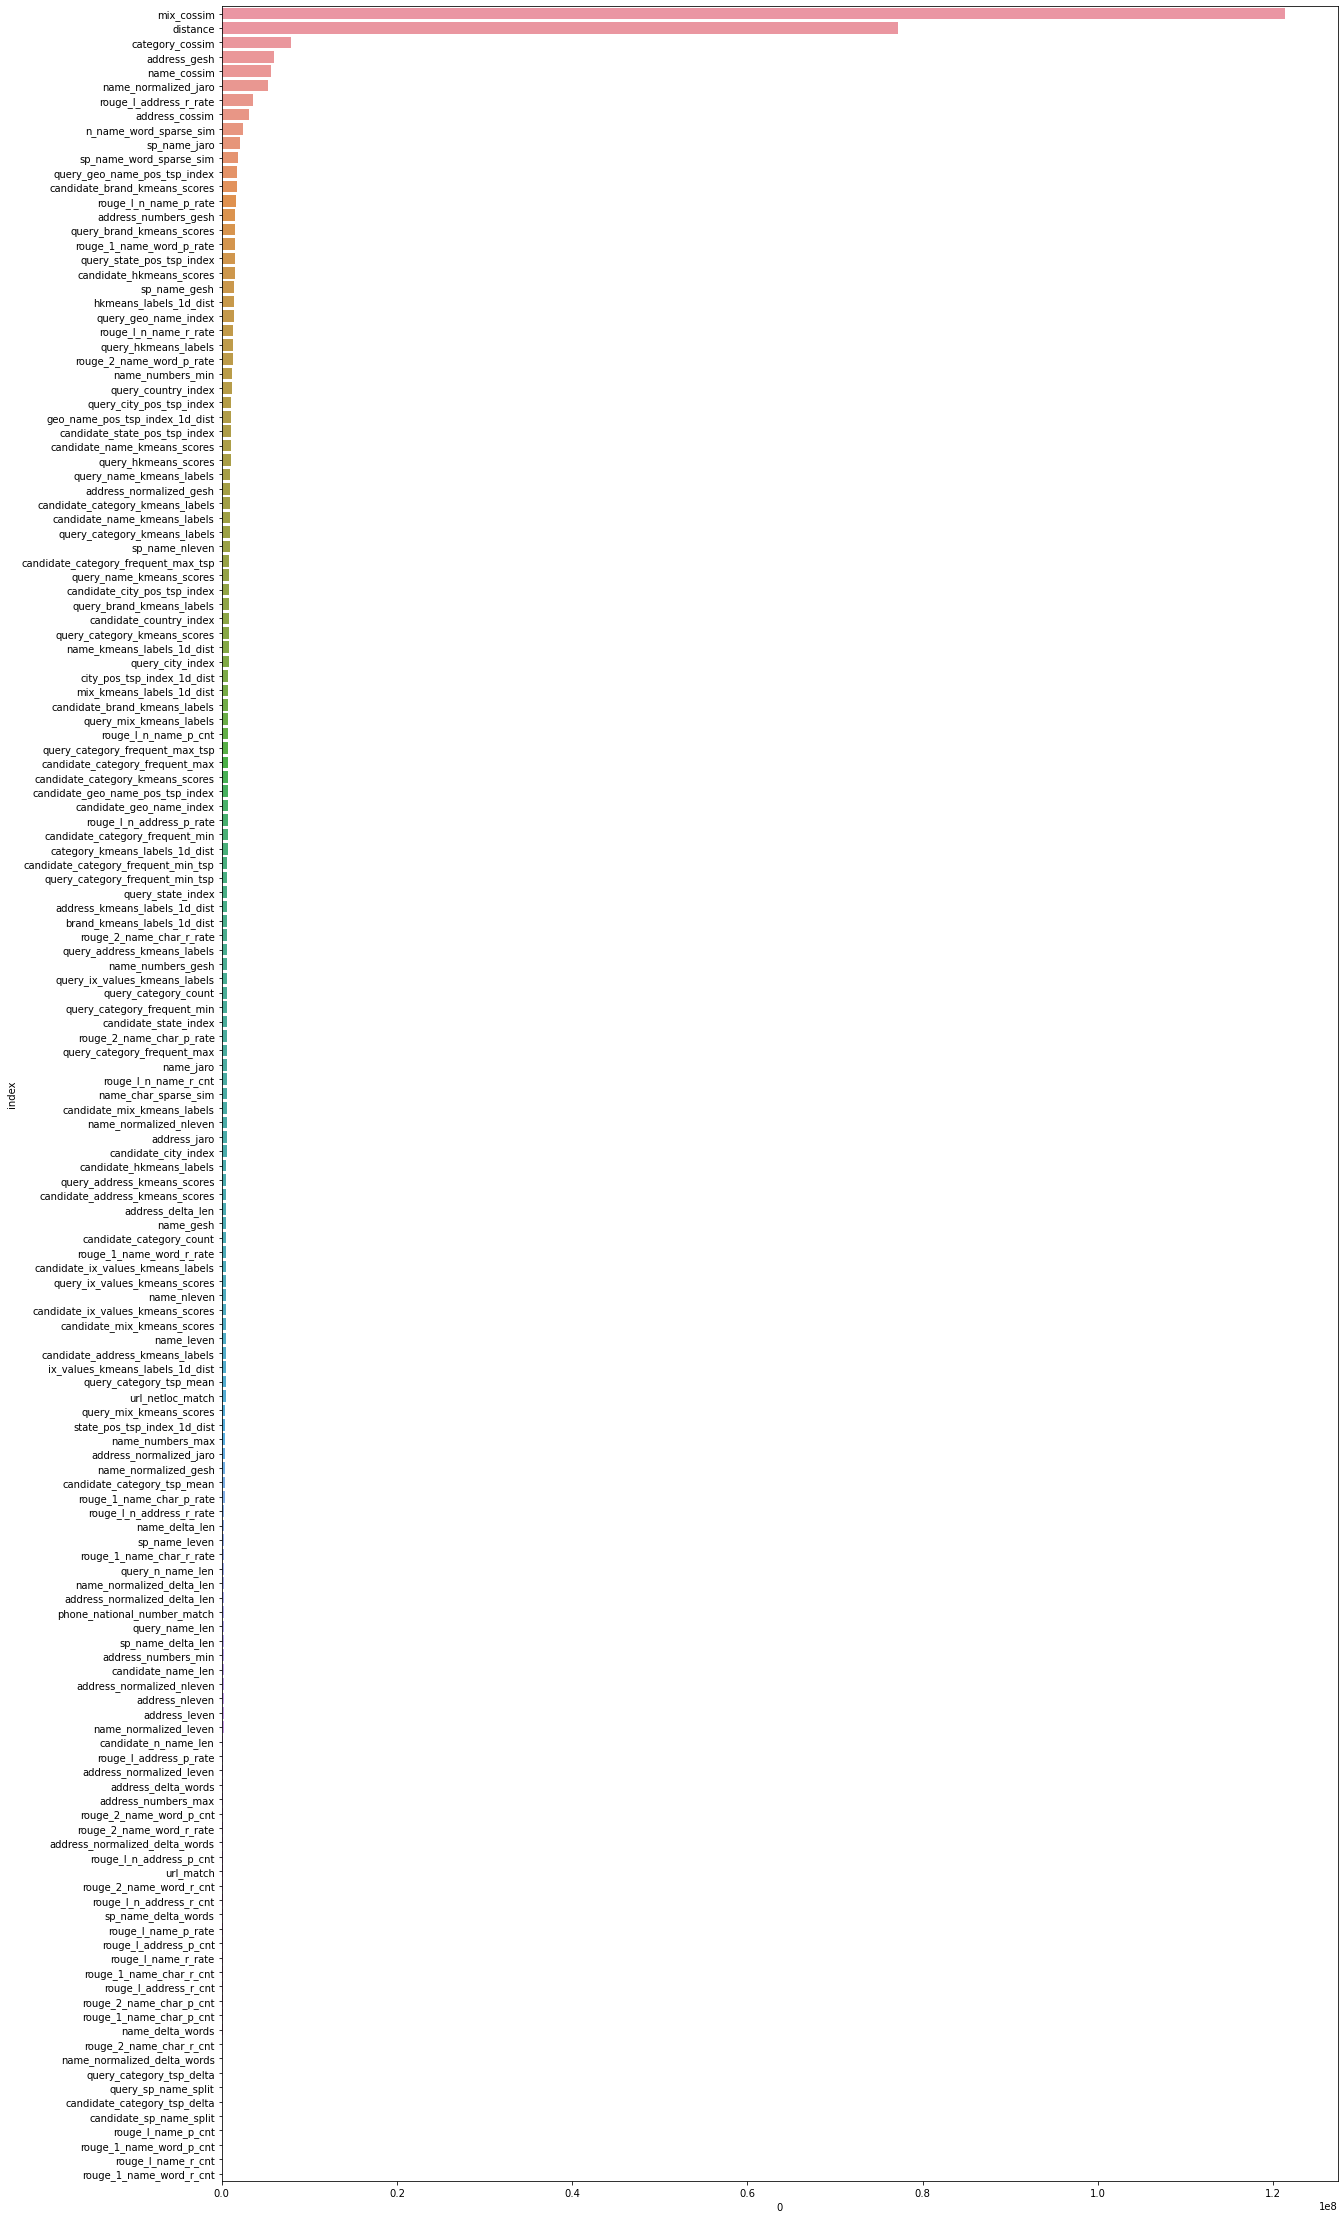

In [143]:
import seaborn as sns

plt.figure(figsize=(20, 40))
f_df = pd.DataFrame(lgb_model.feature_importance(importance_type="gain"), index=feature_cols).sort_values(by=0, ascending=False).reset_index()#.iloc[2:]

sns.barplot(x=0, y="index", data=f_df.reset_index())
plt.savefig(nadare_feature_dir + "feature_importances_gain_pred30_mod1.png")
plt.show()
